In [1]:
# ============================================================================
# IMPORTS E CONFIGURAÇÕES INICIAIS
# ============================================================================

# Bibliotecas fundamentais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown
import time

# Sklearn - Dados e divisão
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                   GridSearchCV, RandomizedSearchCV,
                                   learning_curve, validation_curve,
                                   StratifiedKFold)

# Sklearn - Pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Sklearn - Algoritmos de Classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn - Métricas e Avaliação
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_curve, auc, roc_auc_score, precision_recall_curve)

# Configurações visuais
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11
})

# Suprimir warnings desnecessários
warnings.filterwarnings('ignore')

# Configurar seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# 3. CARREGAMENTO E DESCRIÇÃO DOS DADOS

### 3.1 Carregamento do Dataset

# Carregar o dataset Wisconsin Breast Cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='diagnostico')

# Criar DataFrame completo para análise
df = X.copy()
df['diagnostico'] = y

# Informações básicas do dataset
dataset_info = {
    'Número de amostras': df.shape[0],
    'Número de características': df.shape[1] - 1,
    'Variável target': 'diagnostico (0=Maligno, 1=Benigno)',
    'Tipo de problema': 'Classificação Binária',
    'Valores em falta': df.isnull().sum().sum()
}

display(Markdown("### 3.2 Informações Gerais do Dataset"))
info_df = pd.DataFrame(list(dataset_info.items()), columns=['Característica', 'Valor'])
display(info_df)

### 3.2 Informações Gerais do Dataset

,Característica,Valor
0,Número de amostras,569
1,Número de características,30
2,Variável target,"diagnostico (0=Maligno, 1=Benigno)"
3,Tipo de problema,Classificação Binária
4,Valores em falta,0


#### Distribuição das Classes

,Classe,Contagem,Proporção (%)
0,Maligno (0),357,62.74
1,Benigno (1),212,37.26


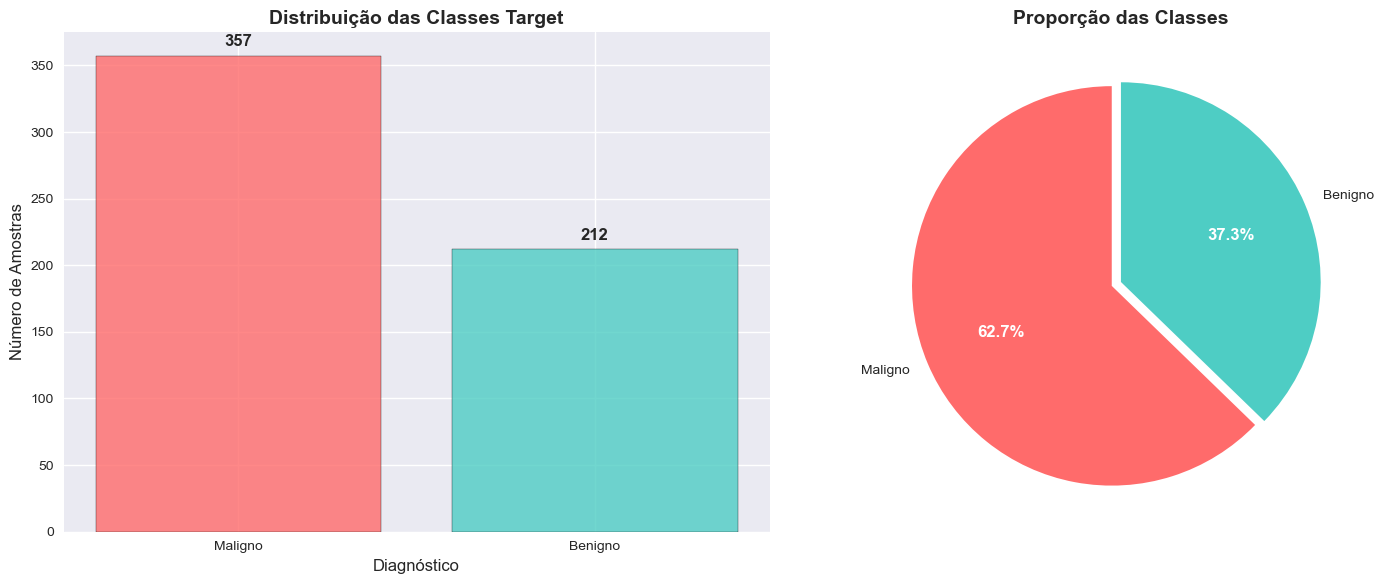

In [5]:
"""
### 3.3 Distribuição das Classes Target

A análise da distribuição das classes é fundamental para identificar potencial 
desequilíbrio que possa impactar o desempenho dos modelos.
"""

# Análise da distribuição das classes
class_distribution = df['diagnostico'].value_counts()
class_proportions = df['diagnostico'].value_counts(normalize=True)

# Criar DataFrame para melhor visualização
distribution_df = pd.DataFrame({
    'Classe': ['Maligno (0)', 'Benigno (1)'],
    'Contagem': class_distribution.values,
    'Proporção (%)': (class_proportions.values * 100).round(2)
})

display(Markdown("#### Distribuição das Classes"))
display(distribution_df)

# Visualização da distribuição das classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
bars = ax1.bar(['Maligno', 'Benigno'], class_distribution.values, 
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
ax1.set_title('Distribuição das Classes Target', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Amostras')
ax1.set_xlabel('Diagnóstico')

# Adicionar valores nas barras
for bar, value in zip(bars, class_distribution.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(value), ha='center', va='bottom', fontweight='bold')

# Gráfico circular
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = ax2.pie(class_distribution.values, 
                                  labels=['Maligno', 'Benigno'],
                                  colors=colors, autopct='%1.1f%%',
                                  startangle=90, explode=(0.05, 0))
ax2.set_title('Proporção das Classes', fontsize=14, fontweight='bold')

# Melhorar aparência do texto
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [6]:
## 4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

### 4.1 Análise Estatística Descritiva
"""
Examinaremos as características estatísticas fundamentais de cada feature para 
compreender a distribuição e identificar potenciais outliers.
"""

# Estatísticas descritivas das características numéricas
numeric_features = [col for col in df.columns if col != 'diagnostico']
desc_stats = df[numeric_features].describe().round(3)

display(Markdown("#### Estatísticas Descritivas (Primeiras 10 características)"))
display(desc_stats.iloc[:, :10].T)  # Mostrar as primeiras 10 features transpostas

# Identificar características com maior variabilidade
cv_stats = (desc_stats.loc['std'] / desc_stats.loc['mean']).sort_values(ascending=False)
high_variability = cv_stats.head(10)

display(Markdown("#### Top 10 Características com Maior Variabilidade (Coeficiente de Variação)"))
variability_df = pd.DataFrame({
    'Característica': high_variability.index,
    'Coeficiente de Variação': high_variability.values.round(3)
})
display(variability_df)

#### Estatísticas Descritivas (Primeiras 10 características)

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127,3.524,6.981,11.700,13.370,15.780,28.110
mean texture,569.0,19.290,4.301,9.710,16.170,18.840,21.800,39.280
mean perimeter,569.0,91.969,24.299,43.790,75.170,86.240,104.100,188.500
mean area,569.0,654.889,351.914,143.500,420.300,551.100,782.700,2501.000
mean smoothness,569.0,0.096,0.014,0.053,0.086,0.096,0.105,0.163
mean compactness,569.0,0.104,0.053,0.019,0.065,0.093,0.130,0.345
mean concavity,569.0,0.089,0.080,0.000,0.030,0.062,0.131,0.427
mean concave points,569.0,0.049,0.039,0.000,0.020,0.034,0.074,0.201
mean symmetry,569.0,0.181,0.027,0.106,0.162,0.179,0.196,0.304
mean fractal dimension,569.0,0.063,0.007,0.050,0.058,0.062,0.066,0.097


#### Top 10 Características com Maior Variabilidade (Coeficiente de Variação)

,Característica,Coeficiente de Variação
0,area error,1.128
1,concavity error,0.938
2,mean concavity,0.899
3,mean concave points,0.796
4,worst concavity,0.768
5,fractal dimension error,0.750
6,compactness error,0.720
7,perimeter error,0.706
8,radius error,0.684
9,worst area,0.647


#### Pares de Características com Correlação > 0.8

,Feature 1,Feature 2,Correlação
0,mean radius,mean perimeter,0.998
36,worst radius,worst perimeter,0.994
1,mean radius,mean area,0.987
7,mean perimeter,mean area,0.987
37,worst radius,worst area,0.984
38,worst perimeter,worst area,0.978
30,radius error,perimeter error,0.973
3,mean radius,worst radius,0.970
10,mean perimeter,worst perimeter,0.970
9,mean perimeter,worst radius,0.969


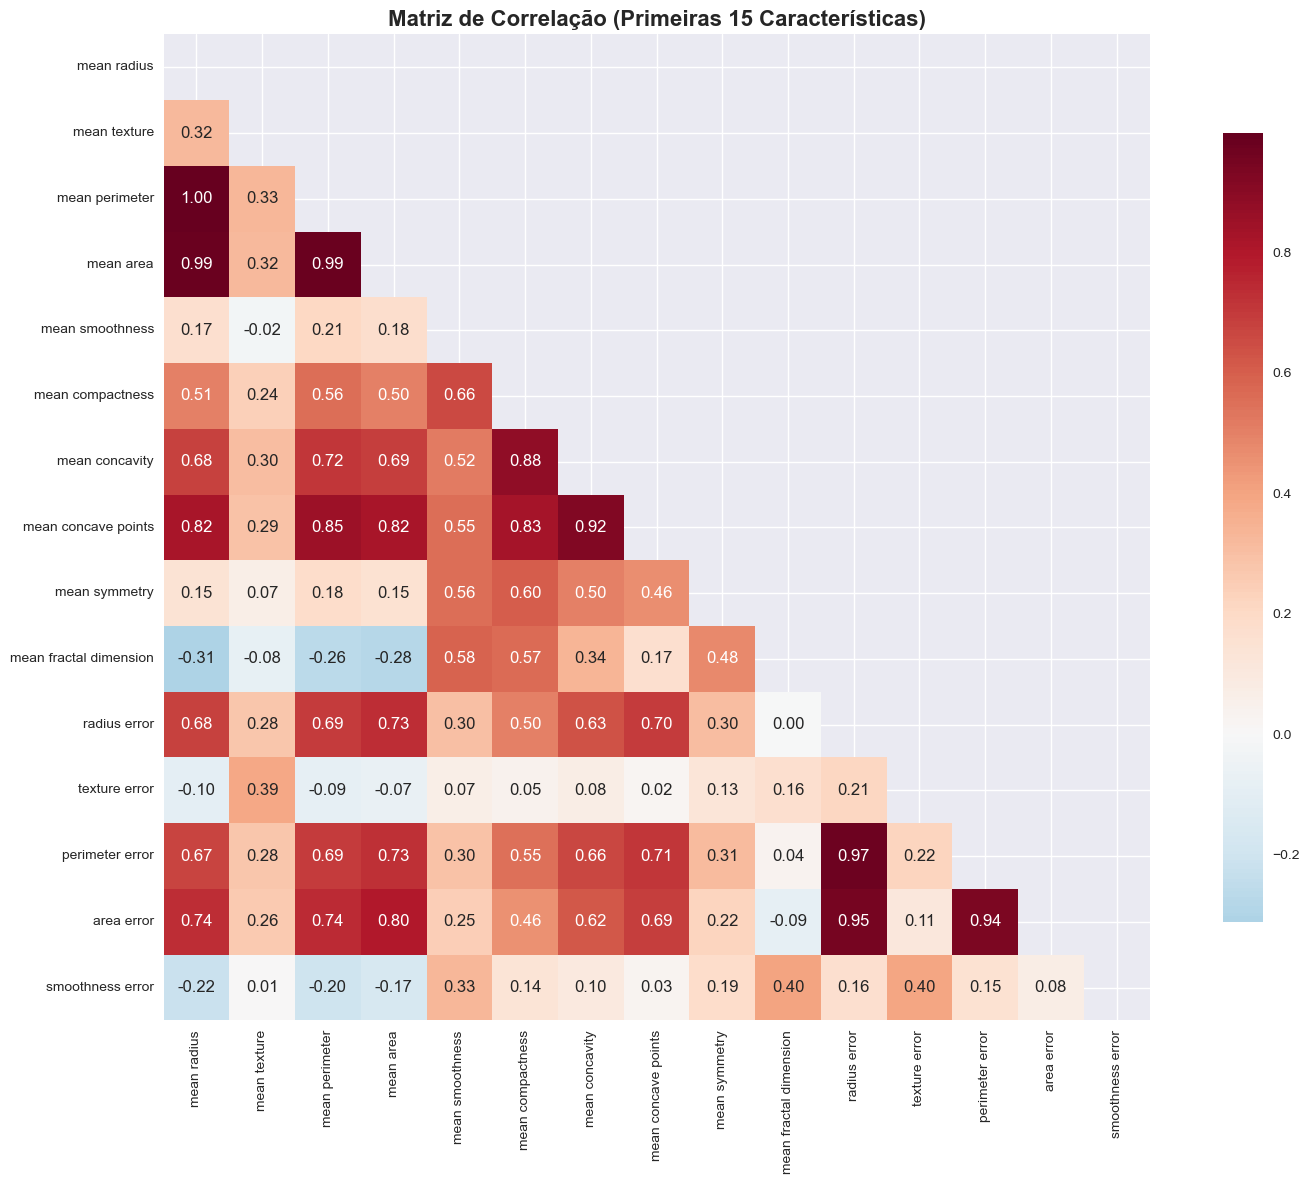

In [12]:
"""
### 4.2 Análise de Correlações

A análise de correlações permite identificar características redundantes e 
compreender relações entre variáveis.
"""

# Calcular matriz de correlação
correlation_matrix = df[numeric_features].corr()

# Identificar correlações altas (>0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlação': round(corr_value, 3)
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlação', key=abs, ascending=False)

display(Markdown("#### Pares de Características com Correlação > 0.8"))
display(high_corr_df.head(15))

# Visualizar matriz de correlação (subset das primeiras 15 features)
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix.iloc[:15, :15], dtype=bool))
sns.heatmap(correlation_matrix.iloc[:15, :15], 
            mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Primeiras 15 Características)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


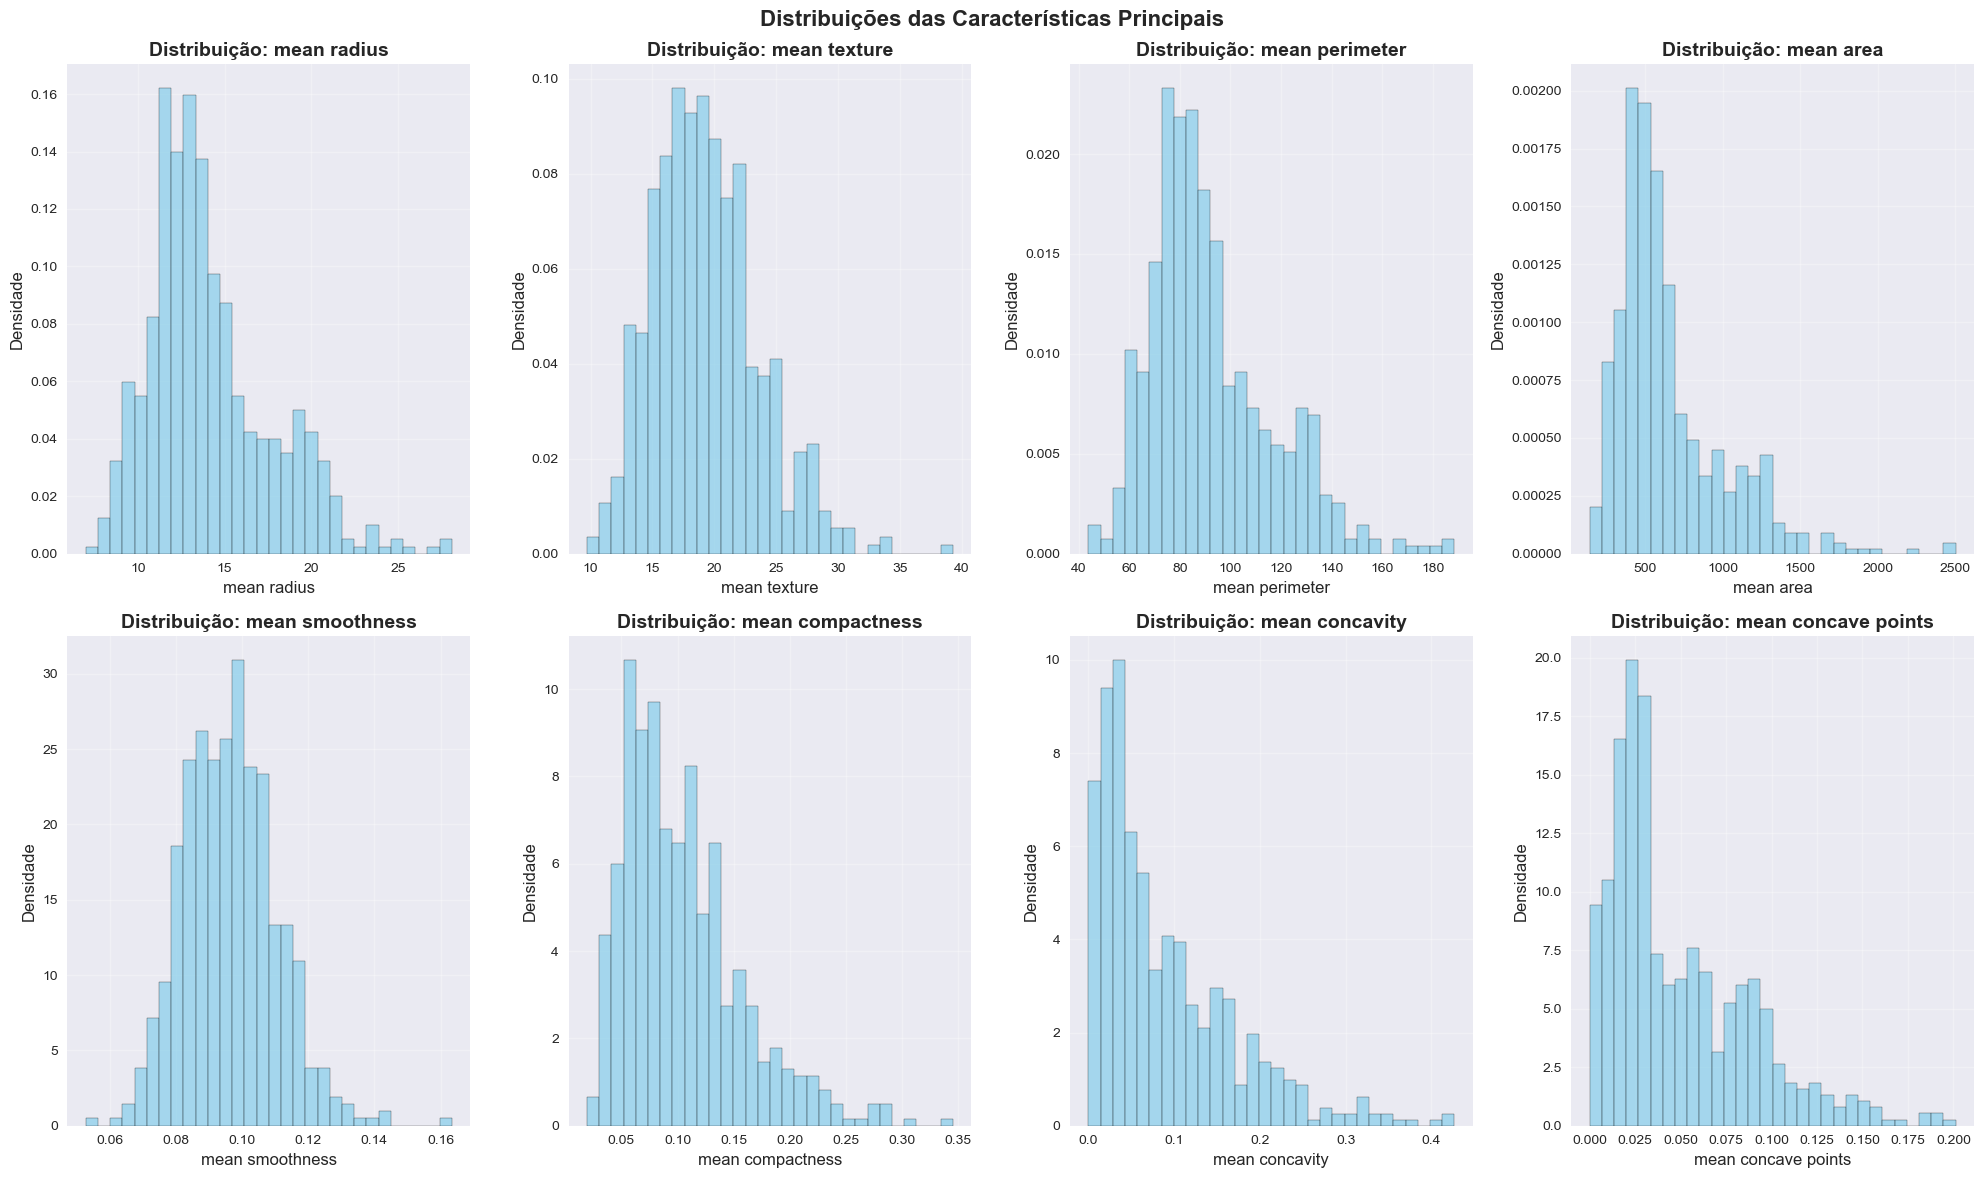

In [13]:
"""
### 4.3 Distribuições das Características Principais

Analisaremos as distribuições das características mais relevantes para compreender 
padrões nos dados.
"""

# Selecionar as 8 características principais baseadas na variabilidade e importância médica
main_features = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points'
]

# Criar subplots para histogramas
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(main_features):
    # Histograma geral
    axes[i].hist(df[feature], bins=30, alpha=0.7, color='skyblue', 
                edgecolor='black', density=True)
    axes[i].set_title(f'Distribuição: {feature}', fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Densidade')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribuições das Características Principais', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


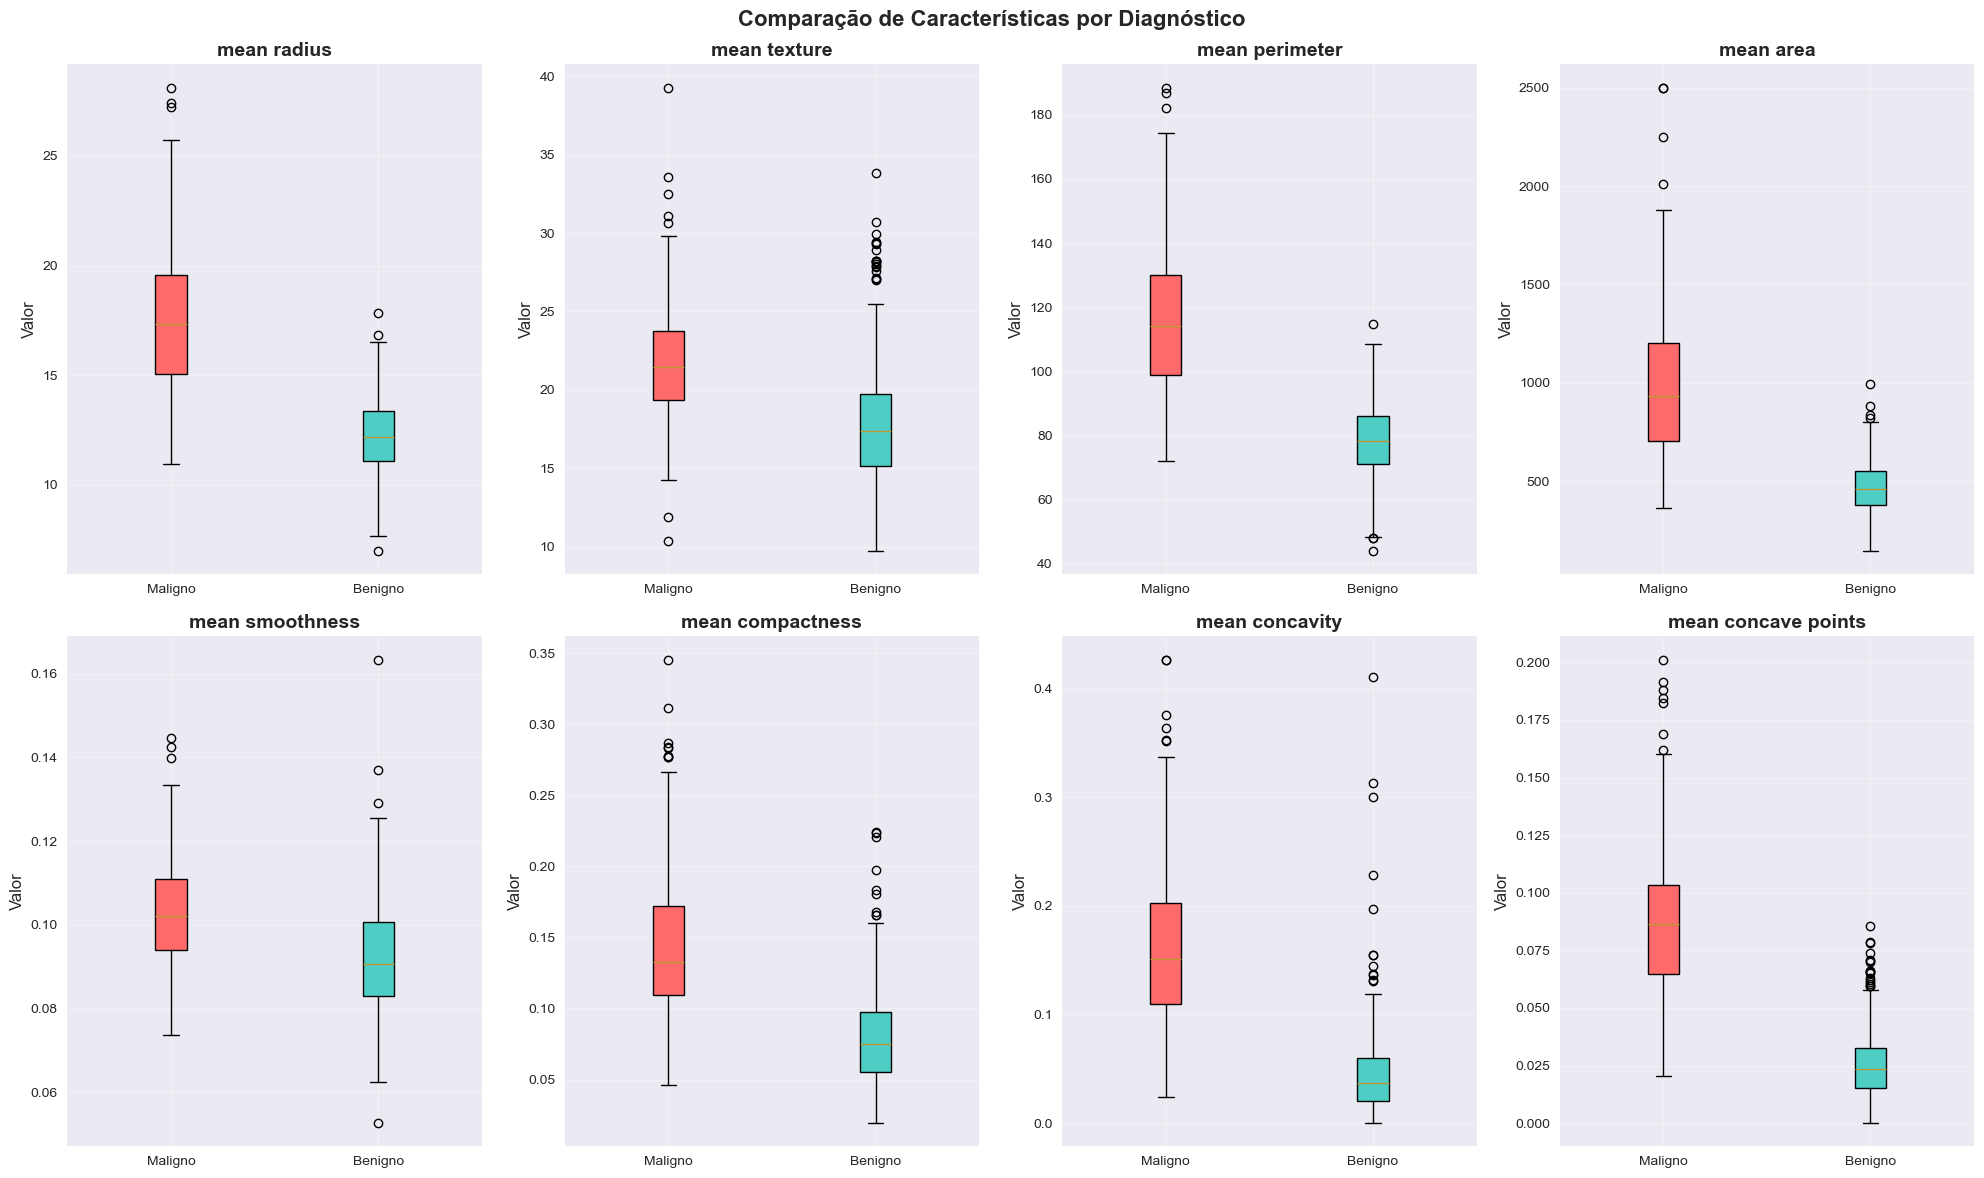

In [14]:
"""
### 4.4 Análise Comparativa por Diagnóstico

Esta análise é crucial para identificar características que melhor discriminam 
entre tumores malignos e benignos.
"""

# Análise comparativa das características principais por diagnóstico
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(main_features):
    # Criar dados para boxplot
    malignant_data = df[df['diagnostico'] == 0][feature]
    benign_data = df[df['diagnostico'] == 1][feature]
    
    # Boxplot comparativo
    box_data = [malignant_data, benign_data]
    bp = axes[i].boxplot(box_data, labels=['Maligno', 'Benigno'], 
                        patch_artist=True, showfliers=True)
    
    # Colorir boxes
    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#4ECDC4')
    
    axes[i].set_title(f'{feature}', fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Comparação de Características por Diagnóstico', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Top 15 Características com Maior Poder Discriminativo

,Característica,Média_Maligno,Média_Benigno,Effect_Size
27,worst concave points,0.182,0.074,1.640
22,worst perimeter,141.370,87.006,1.618
7,mean concave points,0.088,0.026,1.605
20,worst radius,21.135,13.380,1.605
2,mean perimeter,115.365,78.075,1.535
23,worst area,1422.286,558.899,1.516
0,mean radius,17.463,12.147,1.509
3,mean area,978.376,462.790,1.465
6,mean concavity,0.161,0.046,1.439
26,worst concavity,0.451,0.166,1.363


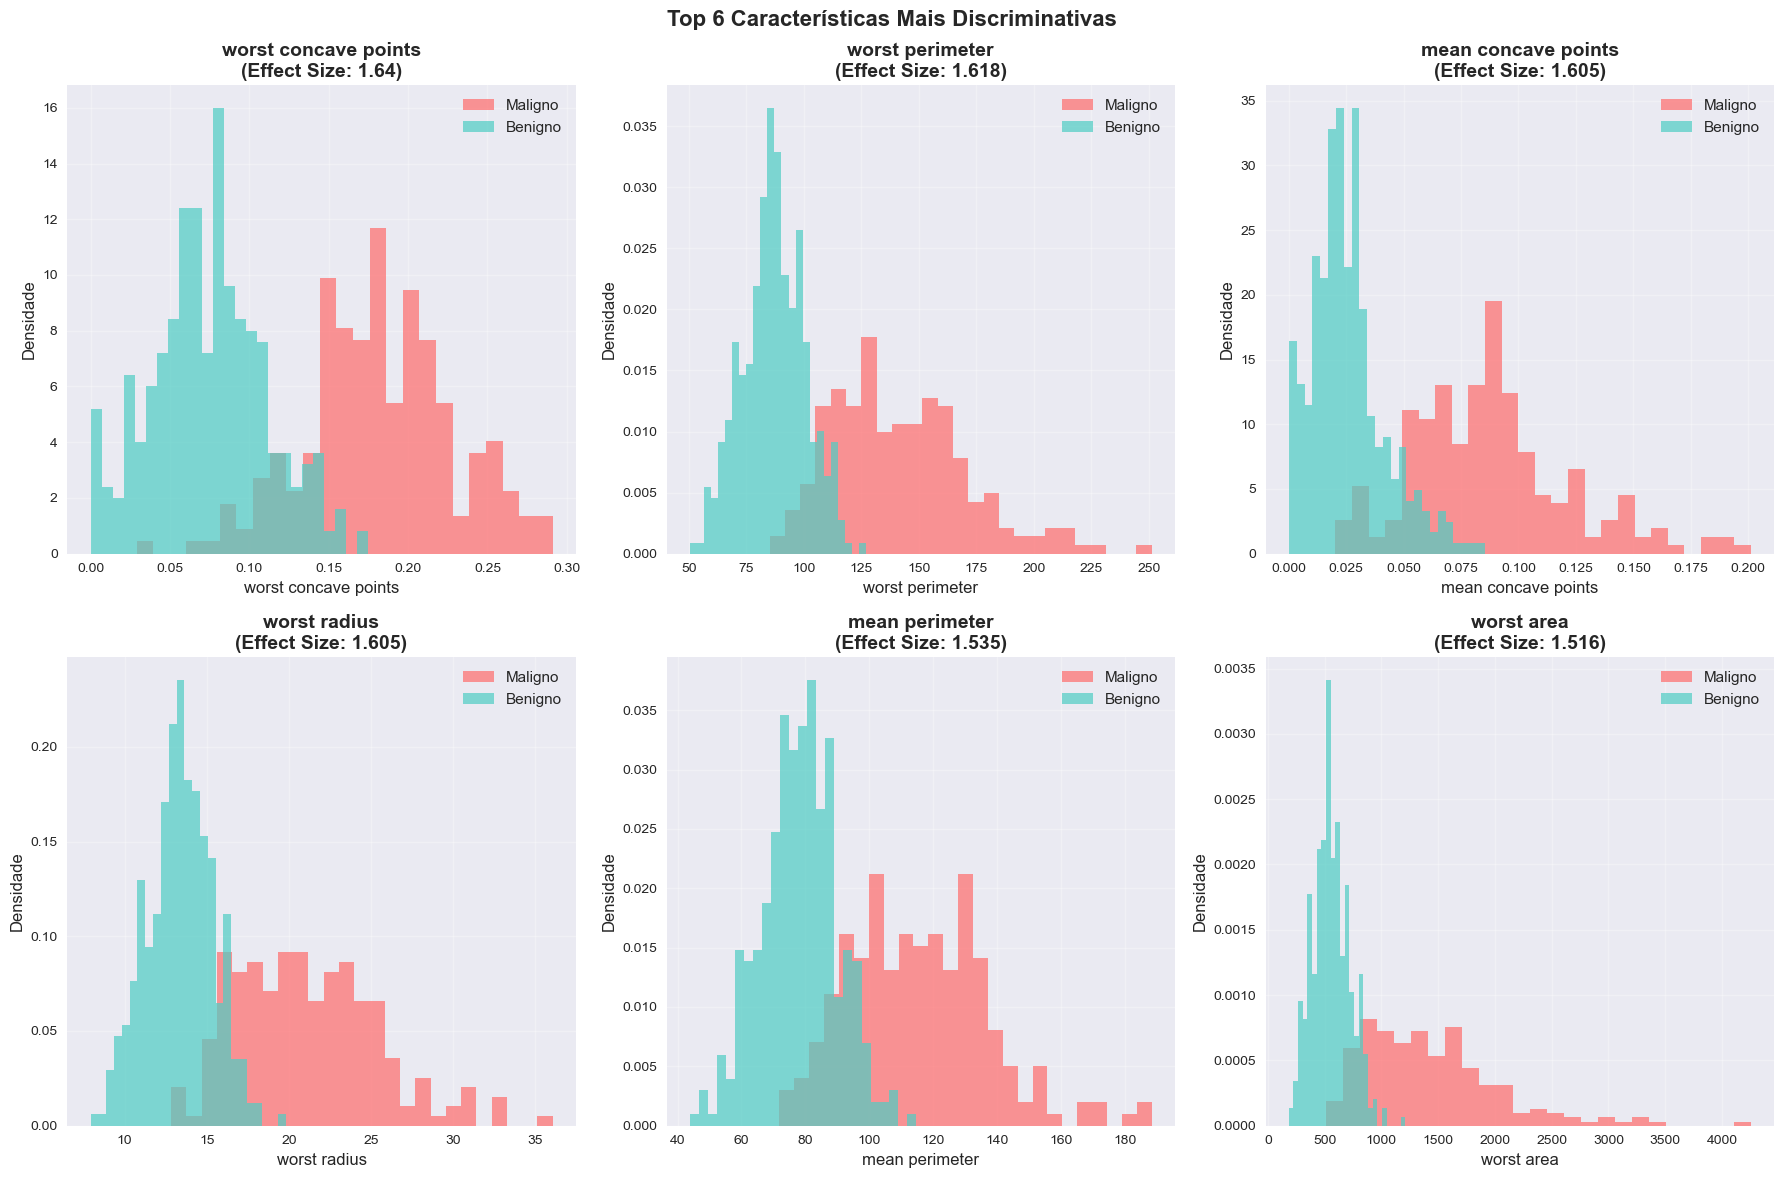

In [15]:
"""
### 4.5 Poder Discriminativo das Características

Calculamos o poder discriminativo de cada característica para identificar 
as mais relevantes para a classificação.
"""

# Calcular poder discriminativo (diferença normalizada das médias)
discriminative_power = []

for feature in numeric_features:
    mean_malignant = df[df['diagnostico'] == 0][feature].mean()
    mean_benign = df[df['diagnostico'] == 1][feature].mean()
    pooled_std = df[feature].std()
    
    # Effect size (Cohen's d)
    effect_size = abs(mean_benign - mean_malignant) / pooled_std
    
    discriminative_power.append({
        'Característica': feature,
        'Média_Maligno': round(mean_malignant, 3),
        'Média_Benigno': round(mean_benign, 3),
        'Effect_Size': round(effect_size, 3)
    })

# Ordenar por poder discriminativo
disc_df = pd.DataFrame(discriminative_power)
disc_df = disc_df.sort_values('Effect_Size', ascending=False)

display(Markdown("#### Top 15 Características com Maior Poder Discriminativo"))
display(disc_df.head(15))

# Visualizar top características discriminativas
top_features = disc_df.head(6)['Característica'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Histogramas sobrepostos
    malignant = df[df['diagnostico'] == 0][feature]
    benign = df[df['diagnostico'] == 1][feature]
    
    axes[i].hist(malignant, alpha=0.7, label='Maligno', bins=25, 
                color='#FF6B6B', density=True)
    axes[i].hist(benign, alpha=0.7, label='Benigno', bins=25, 
                color='#4ECDC4', density=True)
    
    axes[i].set_title(f'{feature}\n(Effect Size: {disc_df[disc_df["Característica"]==feature]["Effect_Size"].iloc[0]})',
                     fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Densidade')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Top 6 Características Mais Discriminativas', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
# 5.2 DIVISÃO DOS DADOS
# ============================================================================

# Separar características e target
X = df[numeric_features]
y = df['diagnostico']

# Divisão estratificada 80/20 para manter proporção das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Verificar manutenção das proporções
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

split_info = pd.DataFrame({
    'Conjunto': ['Treino', 'Teste', 'Original'],
    'Maligno (%)': [
        round(train_distribution[0] * 100, 2),
        round(test_distribution[0] * 100, 2),
        round(class_proportions[0] * 100, 2)
    ],
    'Benigno (%)': [
        round(train_distribution[1] * 100, 2),
        round(test_distribution[1] * 100, 2),
        round(class_proportions[1] * 100, 2)
    ],
    'Total Amostras': [len(y_train), len(y_test), len(y)]
})

display(Markdown("#### Verificação da Divisão Estratificada"))
display(split_info)


#### Verificação da Divisão Estratificada

,Conjunto,Maligno (%),Benigno (%),Total Amostras
0,Treino,37.36,62.64,455
1,Teste,36.84,63.16,114
2,Original,37.26,62.74,569


#### Verificação da Normalização (Primeiras 5 Características)

,Característica,Média_Original,Desvio_Original,Média_Normalizada,Desvio_Normalizada
0,mean radius,14.067,3.499,-0.0,1.001
1,mean texture,19.247,4.405,0.0,1.001
2,mean perimeter,91.557,24.149,-0.0,1.001
3,mean area,648.541,344.945,-0.0,1.001
4,mean smoothness,0.096,0.013,0.0,1.001


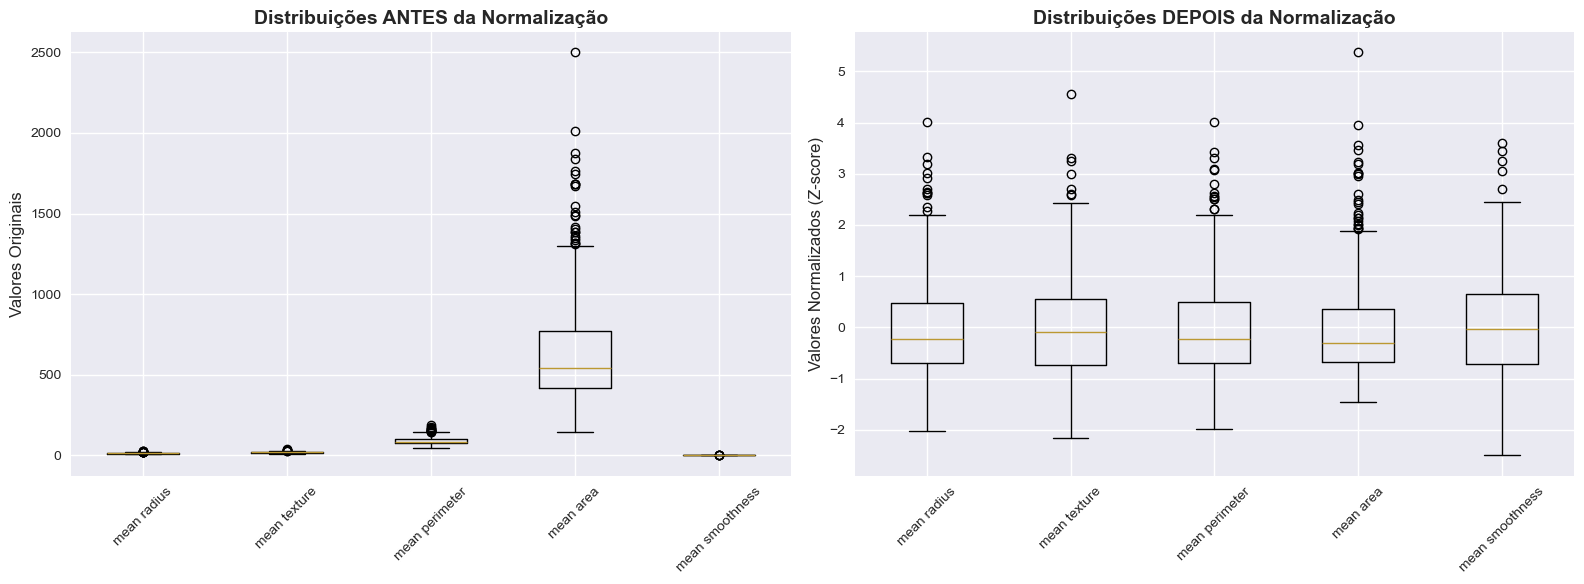

In [18]:
"""
### 5.3 Normalização dos Dados

Aplicamos StandardScaler para centrar os dados na média e normalizar a variância.
"""

# Aplicar StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame mantendo nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, 
                             index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, 
                            index=X_test.index)

# Verificar normalização
normalization_check = pd.DataFrame({
    'Característica': X_train_scaled.columns[:5],  # Primeiras 5 features
    'Média_Original': X_train.iloc[:, :5].mean().round(3).values,
    'Desvio_Original': X_train.iloc[:, :5].std().round(3).values,
    'Média_Normalizada': X_train_scaled.iloc[:, :5].mean().round(3).values,
    'Desvio_Normalizada': X_train_scaled.iloc[:, :5].std().round(3).values
})

display(Markdown("#### Verificação da Normalização (Primeiras 5 Características)"))
display(normalization_check)

# Visualização do efeito da normalização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Antes da normalização
ax1.boxplot([X_train.iloc[:, i] for i in range(5)], 
           labels=[col[:15] + '...' if len(col) > 15 else col 
                  for col in X_train.columns[:5]])
ax1.set_title('Distribuições ANTES da Normalização', fontweight='bold')
ax1.set_ylabel('Valores Originais')
ax1.tick_params(axis='x', rotation=45)

# Depois da normalização
ax2.boxplot([X_train_scaled.iloc[:, i] for i in range(5)], 
           labels=[col[:15] + '...' if len(col) > 15 else col 
                  for col in X_train_scaled.columns[:5]])
ax2.set_title('Distribuições DEPOIS da Normalização', fontweight='bold')
ax2.set_ylabel('Valores Normalizados (Z-score)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Resumo da Seleção de Características

,Métrica,Valor
0,Características Originais,30.0
1,Características Removidas,10.0
2,Características Finais,20.0
3,Redução (%),33.3


#### Características Removidas (Alta Correlação)

,Características Removidas
0,worst radius
1,mean perimeter
2,mean area
3,mean radius
4,worst area
5,area error
6,perimeter error
7,mean concave points
8,mean concavity
9,mean texture


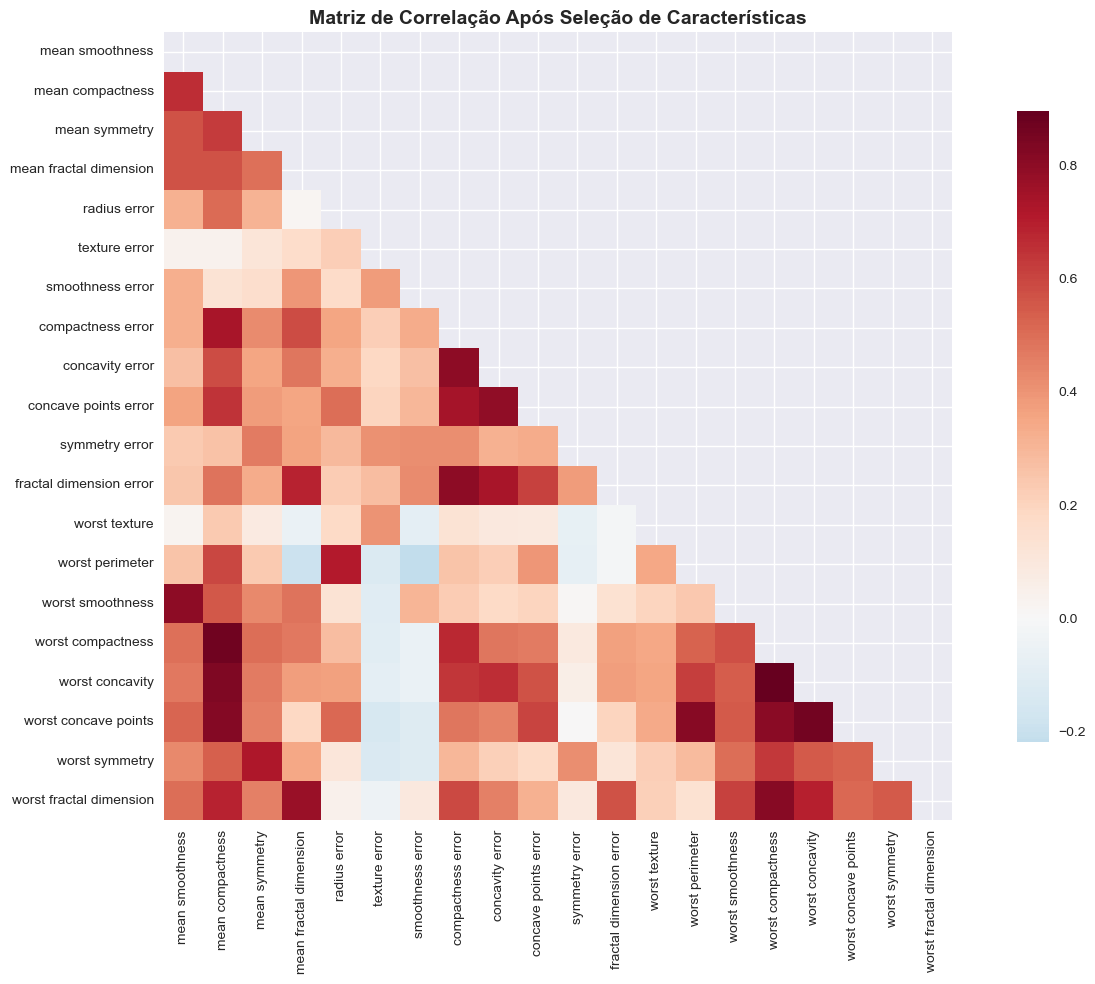

In [19]:
"""
### 5.4 Seleção de Características

Removemos características altamente correlacionadas (>0.9) para reduzir 
multicolinearidade e melhorar a estabilidade dos modelos.
"""

# Calcular matriz de correlação dos dados normalizados
correlation_matrix_scaled = X_train_scaled.corr()

# Identificar características para remoção
features_to_remove = set()
correlation_threshold = 0.9

for i in range(len(correlation_matrix_scaled.columns)):
    for j in range(i+1, len(correlation_matrix_scaled.columns)):
        if abs(correlation_matrix_scaled.iloc[i, j]) > correlation_threshold:
            # Remover a característica com menor poder discriminativo
            feat1 = correlation_matrix_scaled.columns[i]
            feat2 = correlation_matrix_scaled.columns[j]
            
            power1 = disc_df[disc_df['Característica'] == feat1]['Effect_Size'].iloc[0]
            power2 = disc_df[disc_df['Característica'] == feat2]['Effect_Size'].iloc[0]
            
            if power1 < power2:
                features_to_remove.add(feat1)
            else:
                features_to_remove.add(feat2)

# Aplicar seleção de características
X_train_selected = X_train_scaled.drop(columns=features_to_remove)
X_test_selected = X_test_scaled.drop(columns=features_to_remove)

selection_summary = {
    'Características Originais': len(X_train_scaled.columns),
    'Características Removidas': len(features_to_remove),
    'Características Finais': len(X_train_selected.columns),
    'Redução (%)': round((len(features_to_remove) / len(X_train_scaled.columns)) * 100, 1)
}

display(Markdown("#### Resumo da Seleção de Características"))
selection_df = pd.DataFrame(list(selection_summary.items()), 
                          columns=['Métrica', 'Valor'])
display(selection_df)

# Mostrar características removidas
if features_to_remove:
    removed_df = pd.DataFrame({
        'Características Removidas': list(features_to_remove)
    })
    display(Markdown("#### Características Removidas (Alta Correlação)"))
    display(removed_df)

# Visualizar matriz de correlação final
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(X_train_selected.corr(), dtype=bool))
sns.heatmap(X_train_selected.corr(), mask=mask, annot=False, 
           cmap='RdBu_r', center=0, square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação Após Seleção de Características', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
## 6. IMPLEMENTAÇÃO E COMPARAÇÃO DE ALGORITMOS

# 6.2 DEFINIR ALGORITMOS BASELINE
# ============================================================================

# Dicionário com algoritmos e configurações padrão
algorithms_baseline = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'k-NN': KNeighborsClassifier(),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Neural Network': MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
}

# ============================================================================
# 6.3 AVALIAÇÃO BASELINE COM VALIDAÇÃO CRUZADA
# ============================================================================

# Configurar validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Métricas para avaliar
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Armazenar resultados
baseline_results = {}
cv_detailed_results = {}

for name, algorithm in algorithms_baseline.items():
    algorithm_results = {}
    
    # Calcular cada métrica com validação cruzada
    for metric in scoring_metrics:
        cv_scores = cross_val_score(algorithm, X_train_selected, y_train, 
                                  cv=cv_strategy, scoring=metric, n_jobs=-1)
        algorithm_results[metric] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std(),
            'scores': cv_scores
        }
    
    # Medir tempo de treino
    start_time = time.time()
    algorithm.fit(X_train_selected, y_train)
    training_time = time.time() - start_time
    algorithm_results['training_time'] = training_time
    
    baseline_results[name] = algorithm_results
    cv_detailed_results[name] = algorithm_results

# Criar DataFrame com resultados baseline
baseline_summary = pd.DataFrame({
    name: {
        'Accuracy': f"{results['accuracy']['mean']:.4f} ± {results['accuracy']['std']:.4f}",
        'Precision': f"{results['precision']['mean']:.4f} ± {results['precision']['std']:.4f}",
        'Recall': f"{results['recall']['mean']:.4f} ± {results['recall']['std']:.4f}",
        'F1-Score': f"{results['f1']['mean']:.4f} ± {results['f1']['std']:.4f}",
        'AUC': f"{results['roc_auc']['mean']:.4f} ± {results['roc_auc']['std']:.4f}",
        'Tempo_Treino(s)': f"{results['training_time']:.4f}"
    }
    for name, results in baseline_results.items()
}).T

display(Markdown("#### Resultados Baseline (Validação Cruzada 5-fold)"))
display(baseline_summary)

#### Resultados Baseline (Validação Cruzada 5-fold)

,Accuracy,Precision,Recall,F1-Score,AUC,Tempo_Treino(s)
Decision Tree,0.9253 ± 0.0044,0.9359 ± 0.0274,0.9474 ± 0.0294,0.9408 ± 0.0033,0.9178 ± 0.0130,0.0061
k-NN,0.9429 ± 0.0044,0.9337 ± 0.0167,0.9789 ± 0.0172,0.9555 ± 0.0032,0.9735 ± 0.0136,0.0021
SVM,0.9670 ± 0.0184,0.9626 ± 0.0194,0.9860 ± 0.0131,0.9741 ± 0.0144,0.9942 ± 0.0044,0.0130
Random Forest,0.9429 ± 0.0176,0.9578 ± 0.0135,0.9509 ± 0.0258,0.9541 ± 0.0146,0.9872 ± 0.0064,0.1391
Neural Network,0.9626 ± 0.0164,0.9655 ± 0.0189,0.9754 ± 0.0086,0.9704 ± 0.0130,0.9927 ± 0.0087,0.4164
Logistic Regression,0.9736 ± 0.0192,0.9662 ± 0.0209,0.9930 ± 0.0086,0.9793 ± 0.0149,0.9943 ± 0.0063,0.0052


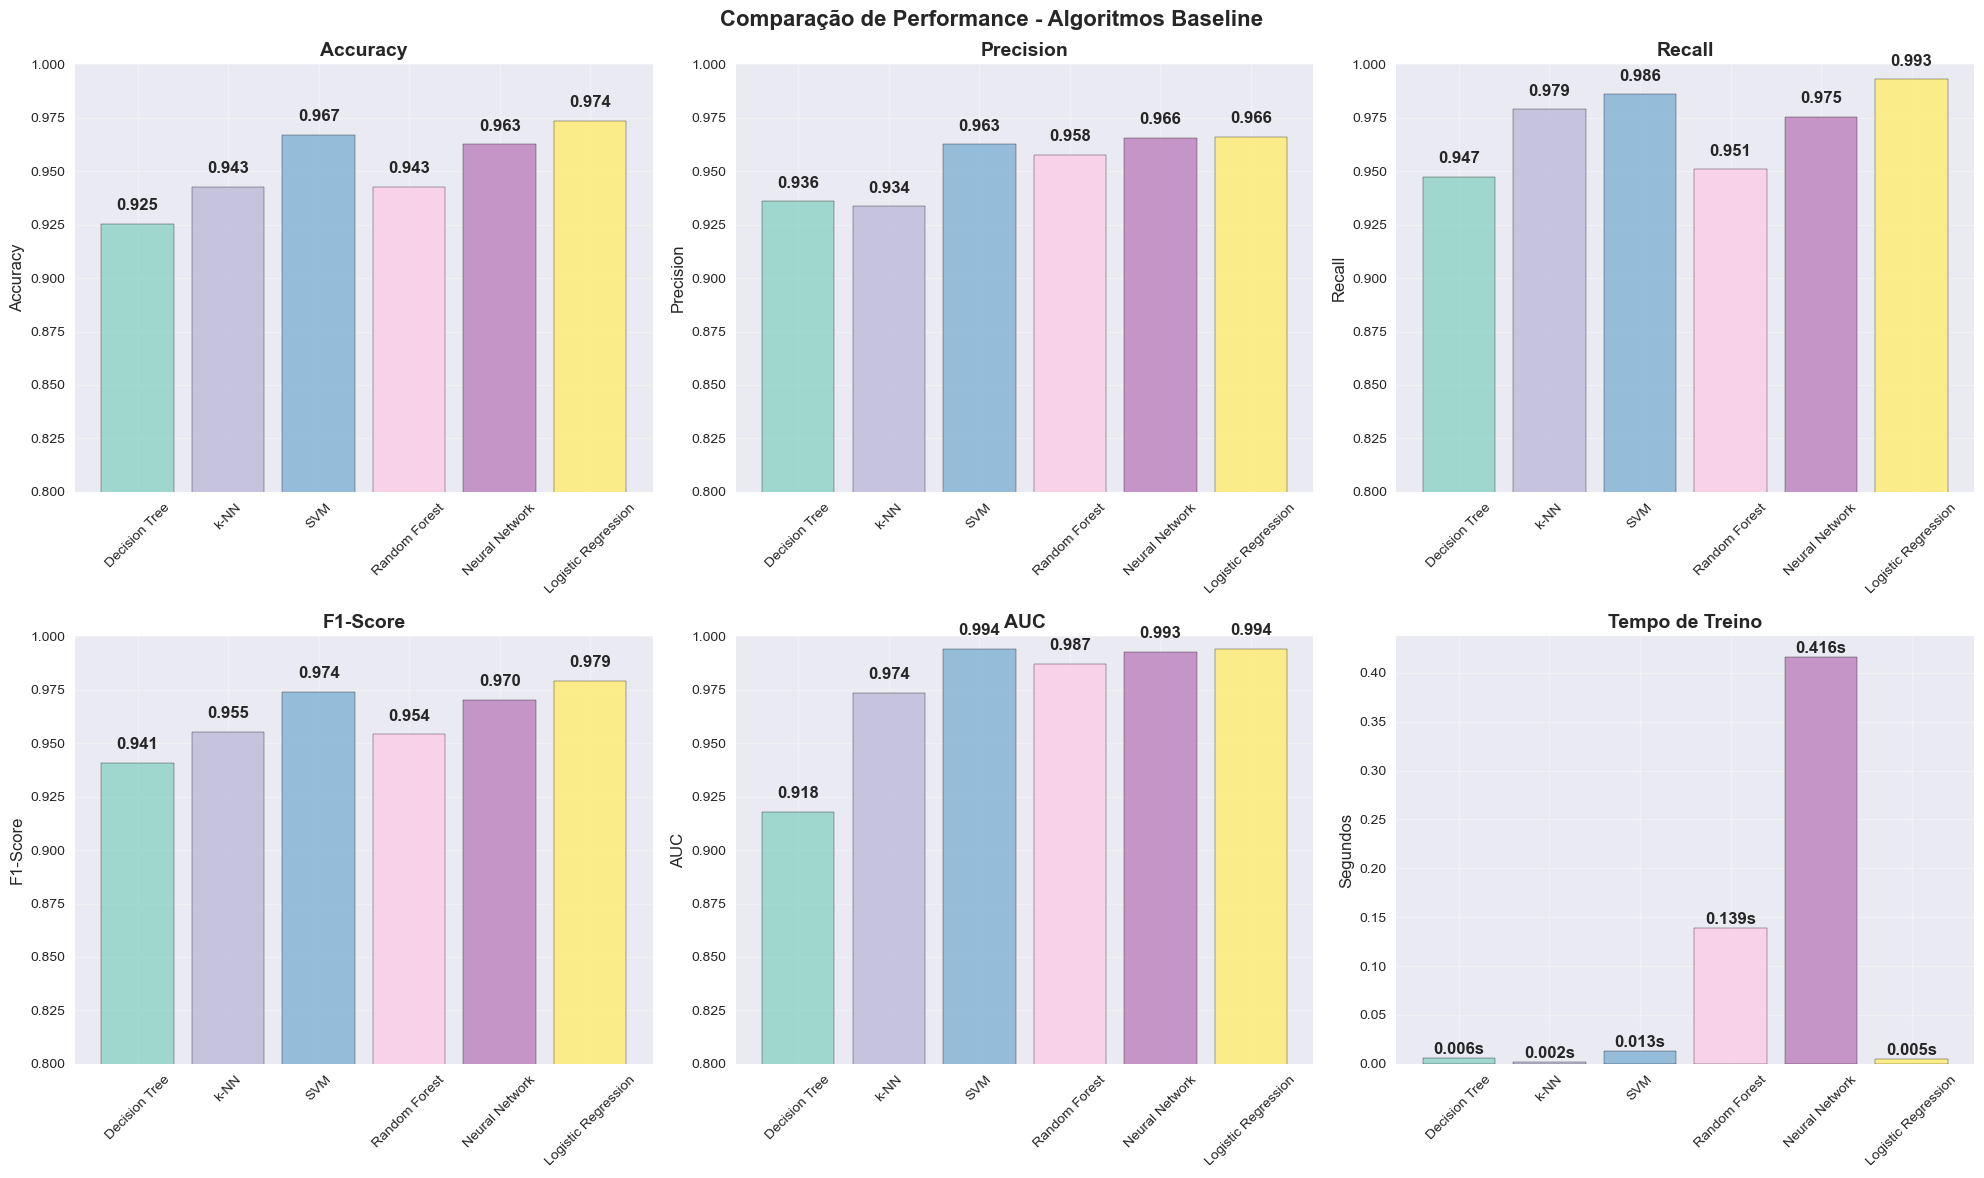

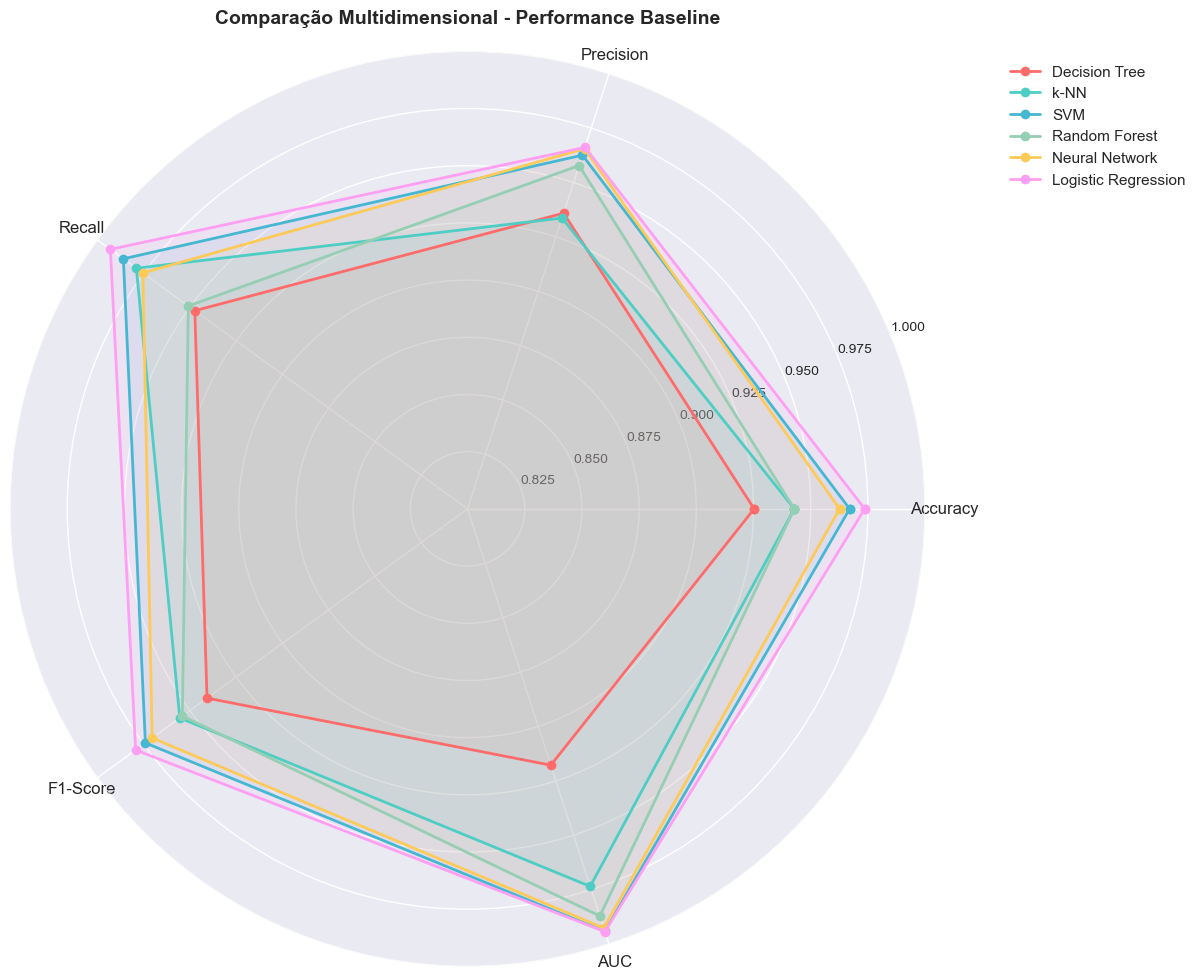

In [21]:
"""
### 6.3 Visualização Comparativa Baseline

Analisamos graficamente o desempenho dos algoritmos para identificar 
os candidatos à otimização.
"""

# Extrair médias para visualização
metrics_means = {
    'Accuracy': [baseline_results[name]['accuracy']['mean'] for name in algorithms_baseline.keys()],
    'Precision': [baseline_results[name]['precision']['mean'] for name in algorithms_baseline.keys()],
    'Recall': [baseline_results[name]['recall']['mean'] for name in algorithms_baseline.keys()],
    'F1-Score': [baseline_results[name]['f1']['mean'] for name in algorithms_baseline.keys()],
    'AUC': [baseline_results[name]['roc_auc']['mean'] for name in algorithms_baseline.keys()]
}

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

algorithm_names = list(algorithms_baseline.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(algorithm_names)))

for idx, (metric, values) in enumerate(metrics_means.items()):
    if idx < 5:  # Apenas as 5 métricas principais
        bars = axes[idx].bar(algorithm_names, values, color=colors, alpha=0.8, edgecolor='black')
        axes[idx].set_title(f'{metric}', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel(metric)
        axes[idx].set_ylim(0.8, 1.0)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, values):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de tempo de treino
training_times = [baseline_results[name]['training_time'] for name in algorithm_names]
bars = axes[5].bar(algorithm_names, training_times, color=colors, alpha=0.8, edgecolor='black')
axes[5].set_title('Tempo de Treino', fontsize=14, fontweight='bold')
axes[5].set_ylabel('Segundos')
axes[5].tick_params(axis='x', rotation=45)
axes[5].grid(True, alpha=0.3)

for bar, value in zip(bars, training_times):
    axes[5].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação de Performance - Algoritmos Baseline', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Radar chart para visualização multidimensional
from math import pi

# Preparar dados para radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Completar o círculo

# Plotar cada algoritmo
colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
for i, (name, color) in enumerate(zip(algorithm_names, colors_radar)):
    values = [metrics_means[cat][i] for cat in categories]
    values += values[:1]  # Completar o círculo
    
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.8, 1.0)
ax.set_title('Comparação Multidimensional - Performance Baseline', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

In [23]:
## 7. OTIMIZAÇÃO DE HIPERPARÂMETROS

# 7.2 OTIMIZAÇÃO - LOGISTIC REGRESSION
# ============================================================================

# Grids separados para diferentes combinações válidas de solver/penalty
lr_param_grids = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [1000, 2000],
        'class_weight': [None, 'balanced']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': [None, 'balanced']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': [None, 'balanced']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': [None],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': [None, 'balanced']
    }
]

# Grid search para Logistic Regression
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    param_grid=lr_param_grids,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

start_time = time.time()
lr_grid_search.fit(X_train_selected, y_train)
lr_optimization_time = time.time() - start_time

best_lr = lr_grid_search.best_estimator_


In [24]:
# 7.3 OTIMIZAÇÃO - K-NEAREST NEIGHBORS
# ============================================================================

knn_param_grid = {
    'n_neighbors': list(range(1, 31, 2)),                 # 1, 3, 5, ..., 29
    'weights': ['uniform', 'distance'],                   # Tipo de peso
    'metric': ['euclidean', 'manhattan', 'minkowski'],    # Métrica distância
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],      # Algoritmo
    'p': [1, 2]                                           # Para minkowski
}

knn_random_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_grid,
    n_iter=100,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

start_time = time.time()
knn_random_search.fit(X_train_selected, y_train)
knn_optimization_time = time.time() - start_time

best_knn = knn_random_search.best_estimator_

In [ ]:
# 7.4 OTIMIZAÇÃO - SUPPORT VECTOR MACHINE
# ============================================================================

svm_param_grid = [
    {
        'kernel': ['linear'],  # Usa o kernel linear para SVM
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Testa diferentes valores de regularização
        'class_weight': [None, 'balanced']  # Considera balanceamento de classes ou não
    },
    {
        'kernel': ['rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Testa diferentes valores de gamma para o kernel RBF
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    }
]

svm_grid_search = GridSearchCV(
    estimator=SVC(random_state=RANDOM_STATE, probability=True),
    param_grid=svm_param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

start_time = time.time()
svm_grid_search.fit(X_train_selected, y_train)
svm_optimization_time = time.time() - start_time

best_svm = svm_grid_search.best_estimator_

In [26]:
# 7.5 OTIMIZAÇÃO - RANDOM FOREST
# ============================================================================

rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],                  # Número árvores
    'max_depth': [None, 5, 10, 15, 20],                   # Profundidade máxima
    'min_samples_split': [2, 5, 10],                      # Min amostras split
    'min_samples_leaf': [1, 2, 4],                        # Min amostras folha
    'max_features': ['sqrt', 'log2', None],               # Features por split
    'bootstrap': [True, False],                           # Bootstrap sampling
    'class_weight': [None, 'balanced']                    # Balanceamento
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=100,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

start_time = time.time()
rf_random_search.fit(X_train_selected, y_train)
rf_optimization_time = time.time() - start_time

best_rf = rf_random_search.best_estimator_

In [27]:
# 7.6 OTIMIZAÇÃO - NEURAL NETWORK
# ============================================================================

nn_param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (200,),                            # 1 camada
        (50, 50), (100, 50), (100, 100),                 # 2 camadas
        (100, 50, 25)                                     # 3 camadas
    ],
    'activation': ['tanh', 'relu', 'logistic'],          # Função ativação
    'solver': ['adam', 'lbfgs'],                          # Otimizador
    'alpha': [0.0001, 0.001, 0.01],                      # Regularização L2
    'learning_rate': ['constant', 'adaptive'],           # Taxa aprendizagem
    'learning_rate_init': [0.001, 0.01],                 # Taxa inicial
    'max_iter': [1000, 2000]                             # Iterações máximas
}

nn_random_search = RandomizedSearchCV(
    estimator=MLPClassifier(random_state=RANDOM_STATE, early_stopping=True),
    param_distributions=nn_param_grid,
    n_iter=50,
    cv=3,  # CV menor para velocidade
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

start_time = time.time()
nn_random_search.fit(X_train_selected, y_train)
nn_optimization_time = time.time() - start_time

best_nn = nn_random_search.best_estimator_

In [28]:
# 7.7 OTIMIZAÇÃO - DECISION TREE
# ============================================================================

dt_param_grid = {
    'criterion': ['gini', 'entropy'],                     # Critério divisão
    'max_depth': [None, 3, 5, 7, 10, 15],                # Profundidade máxima
    'min_samples_split': [2, 5, 10, 20],                 # Min amostras split
    'min_samples_leaf': [1, 2, 5, 10],                   # Min amostras folha
    'max_features': [None, 'sqrt', 'log2'],              # Features por split
    'class_weight': [None, 'balanced'],                  # Balanceamento
    'splitter': ['best', 'random']                       # Estratégia split
}

dt_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=dt_param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

start_time = time.time()
dt_grid_search.fit(X_train_selected, y_train)
dt_optimization_time = time.time() - start_time

best_dt = dt_grid_search.best_estimator_

In [29]:
# 7.8 RESUMO DA OTIMIZAÇÃO
# ============================================================================

# Dicionário com modelos otimizados
optimized_models = {
    'Logistic Regression': best_lr,
    'k-NN': best_knn,
    'SVM': best_svm,
    'Random Forest': best_rf,
    'Neural Network': best_nn,
    'Decision Tree': best_dt
}

# Resumo dos tempos de otimização
optimization_times = {
    'Logistic Regression': lr_optimization_time,
    'k-NN': knn_optimization_time,
    'SVM': svm_optimization_time,
    'Random Forest': rf_optimization_time,
    'Neural Network': nn_optimization_time,
    'Decision Tree': dt_optimization_time
}

# Melhores hiperparâmetros encontrados
best_params_summary = {}
search_objects = {
    'Logistic Regression': lr_grid_search,
    'k-NN': knn_random_search,
    'SVM': svm_grid_search,
    'Random Forest': rf_random_search,
    'Neural Network': nn_random_search,
    'Decision Tree': dt_grid_search
}

for name, search_obj in search_objects.items():
    best_params_summary[name] = search_obj.best_params_

display(Markdown("#### Tempos de Otimização"))
optimization_times_df = pd.DataFrame(list(optimization_times.items()), 
                                   columns=['Algoritmo', 'Tempo (segundos)'])
optimization_times_df['Tempo (segundos)'] = optimization_times_df['Tempo (segundos)'].round(2)
display(optimization_times_df)

#### Tempos de Otimização

,Algoritmo,Tempo (segundos)
0,Logistic Regression,10.30
1,k-NN,2.10
2,SVM,2.60
3,Random Forest,23.91
4,Neural Network,1.47
5,Decision Tree,11.78


In [30]:
### 7.9 Melhores Hiperparâmetros Encontrados
# Apresentamos os hiperparâmetros óptimos identificados para cada algoritmo.


# Mostrar melhores parâmetros para cada modelo
for name, params in best_params_summary.items():
    display(Markdown(f"#### {name}"))
    params_df = pd.DataFrame(list(params.items()), columns=['Parâmetro', 'Valor Óptimo'])
    display(params_df)

#### Logistic Regression

,Parâmetro,Valor Óptimo
0,C,1
1,class_weight,None
2,max_iter,1000
3,penalty,l1
4,solver,liblinear


#### k-NN

,Parâmetro,Valor Óptimo
0,weights,distance
1,p,1
2,n_neighbors,3
3,metric,manhattan
4,algorithm,kd_tree


#### SVM

,Parâmetro,Valor Óptimo
0,C,1
1,class_weight,None
2,gamma,auto
3,kernel,rbf


#### Random Forest

,Parâmetro,Valor Óptimo
0,n_estimators,100
1,min_samples_split,2
2,min_samples_leaf,2
3,max_features,None
4,max_depth,20
5,class_weight,balanced
6,bootstrap,True


#### Neural Network

,Parâmetro,Valor Óptimo
0,solver,lbfgs
1,max_iter,2000
2,learning_rate_init,0.001
3,learning_rate,constant
4,hidden_layer_sizes,"(50,)"
5,alpha,0.01
6,activation,logistic


#### Decision Tree

,Parâmetro,Valor Óptimo
0,class_weight,balanced
1,criterion,entropy
2,max_depth,7
3,max_features,None
4,min_samples_leaf,1
5,min_samples_split,5
6,splitter,random


In [ ]:
## 8. AVALIAÇÃO FINAL DOS MODELOS OTIMIZADOS

### 8.1 Avaliação Completa no Conjunto de Teste

# Avaliamos os modelos otimizados no conjunto de teste, usando múltiplas métricas 
# para análise abrangente do desempenho.

# 8.1 AVALIAÇÃO FINAL DOS MODELOS OTIMIZADOS
# ============================================================================

final_results = {}
confusion_matrices = {}
roc_data = {}

for name, model in optimized_models.items():
    # Treinar modelo final no conjunto completo de treino
    start_time = time.time()
    model.fit(X_train_selected, y_train)
    training_time = time.time() - start_time
    
    # Fazer predições no conjunto de teste
    start_time = time.time()
    y_pred = model.predict(X_test_selected)
    prediction_time = time.time() - start_time
    
    # Probabilidades para AUC (se disponível)
    try:
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    except:
        y_pred_proba = None
    
    # Calcular todas as métricas
    final_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'Training_Time': training_time,
        'Prediction_Time': prediction_time
    }
    
    # Matriz de confusão
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    
    # Dados para curva ROC
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}

# Criar DataFrame com resultados finais
final_results_df = pd.DataFrame(final_results).T
final_results_df = final_results_df.round(4)

display(Markdown("#### Resultados Finais - Modelos Otimizados (Conjunto de Teste)"))
display(final_results_df)

#### Resultados Finais - Modelos Otimizados (Conjunto de Teste)

,Accuracy,Precision,Recall,F1-Score,AUC,Training_Time,Prediction_Time
Logistic Regression,0.9825,0.9861,0.9861,0.9861,0.9974,0.0030,0.0000
k-NN,0.9386,0.9333,0.9722,0.9524,0.9927,0.0014,0.0025
SVM,0.9737,0.9726,0.9861,0.9793,0.9957,0.0131,0.0020
Random Forest,0.9298,0.9444,0.9444,0.9444,0.9901,0.1369,0.0183
Neural Network,0.9737,0.9859,0.9722,0.9790,0.9937,0.0292,0.0025
Decision Tree,0.9035,0.9552,0.8889,0.9209,0.9375,0.0020,0.0010


In [33]:
### 8.2 Validação Cruzada dos Modelos Otimizados
"""
Para garantir robustez dos resultados, realizamos validação cruzada dos 
modelos otimizados.
"""

# Validação cruzada dos modelos otimizados
cv_optimized_results = {}

for name, model in optimized_models.items():
    cv_scores = cross_val_score(model, X_train_selected, y_train, 
                               cv=cv_strategy, scoring='f1', n_jobs=-1)
    
    cv_optimized_results[name] = {
        'F1_Mean': cv_scores.mean(),
        'F1_Std': cv_scores.std(),
        'F1_Min': cv_scores.min(),
        'F1_Max': cv_scores.max()
    }

cv_optimized_df = pd.DataFrame(cv_optimized_results).T
cv_optimized_df = cv_optimized_df.round(4)

display(Markdown("#### Validação Cruzada - Modelos Otimizados"))
display(cv_optimized_df)

#### Validação Cruzada - Modelos Otimizados

,F1_Mean,F1_Std,F1_Min,F1_Max
Logistic Regression,0.9842,0.0067,0.9735,0.9913
k-NN,0.9604,0.0045,0.9558,0.9661
SVM,0.9757,0.0127,0.9565,0.9913
Random Forest,0.9684,0.0091,0.9558,0.9825
Neural Network,0.9684,0.0131,0.9474,0.9828
Decision Tree,0.9576,0.0172,0.9464,0.9913


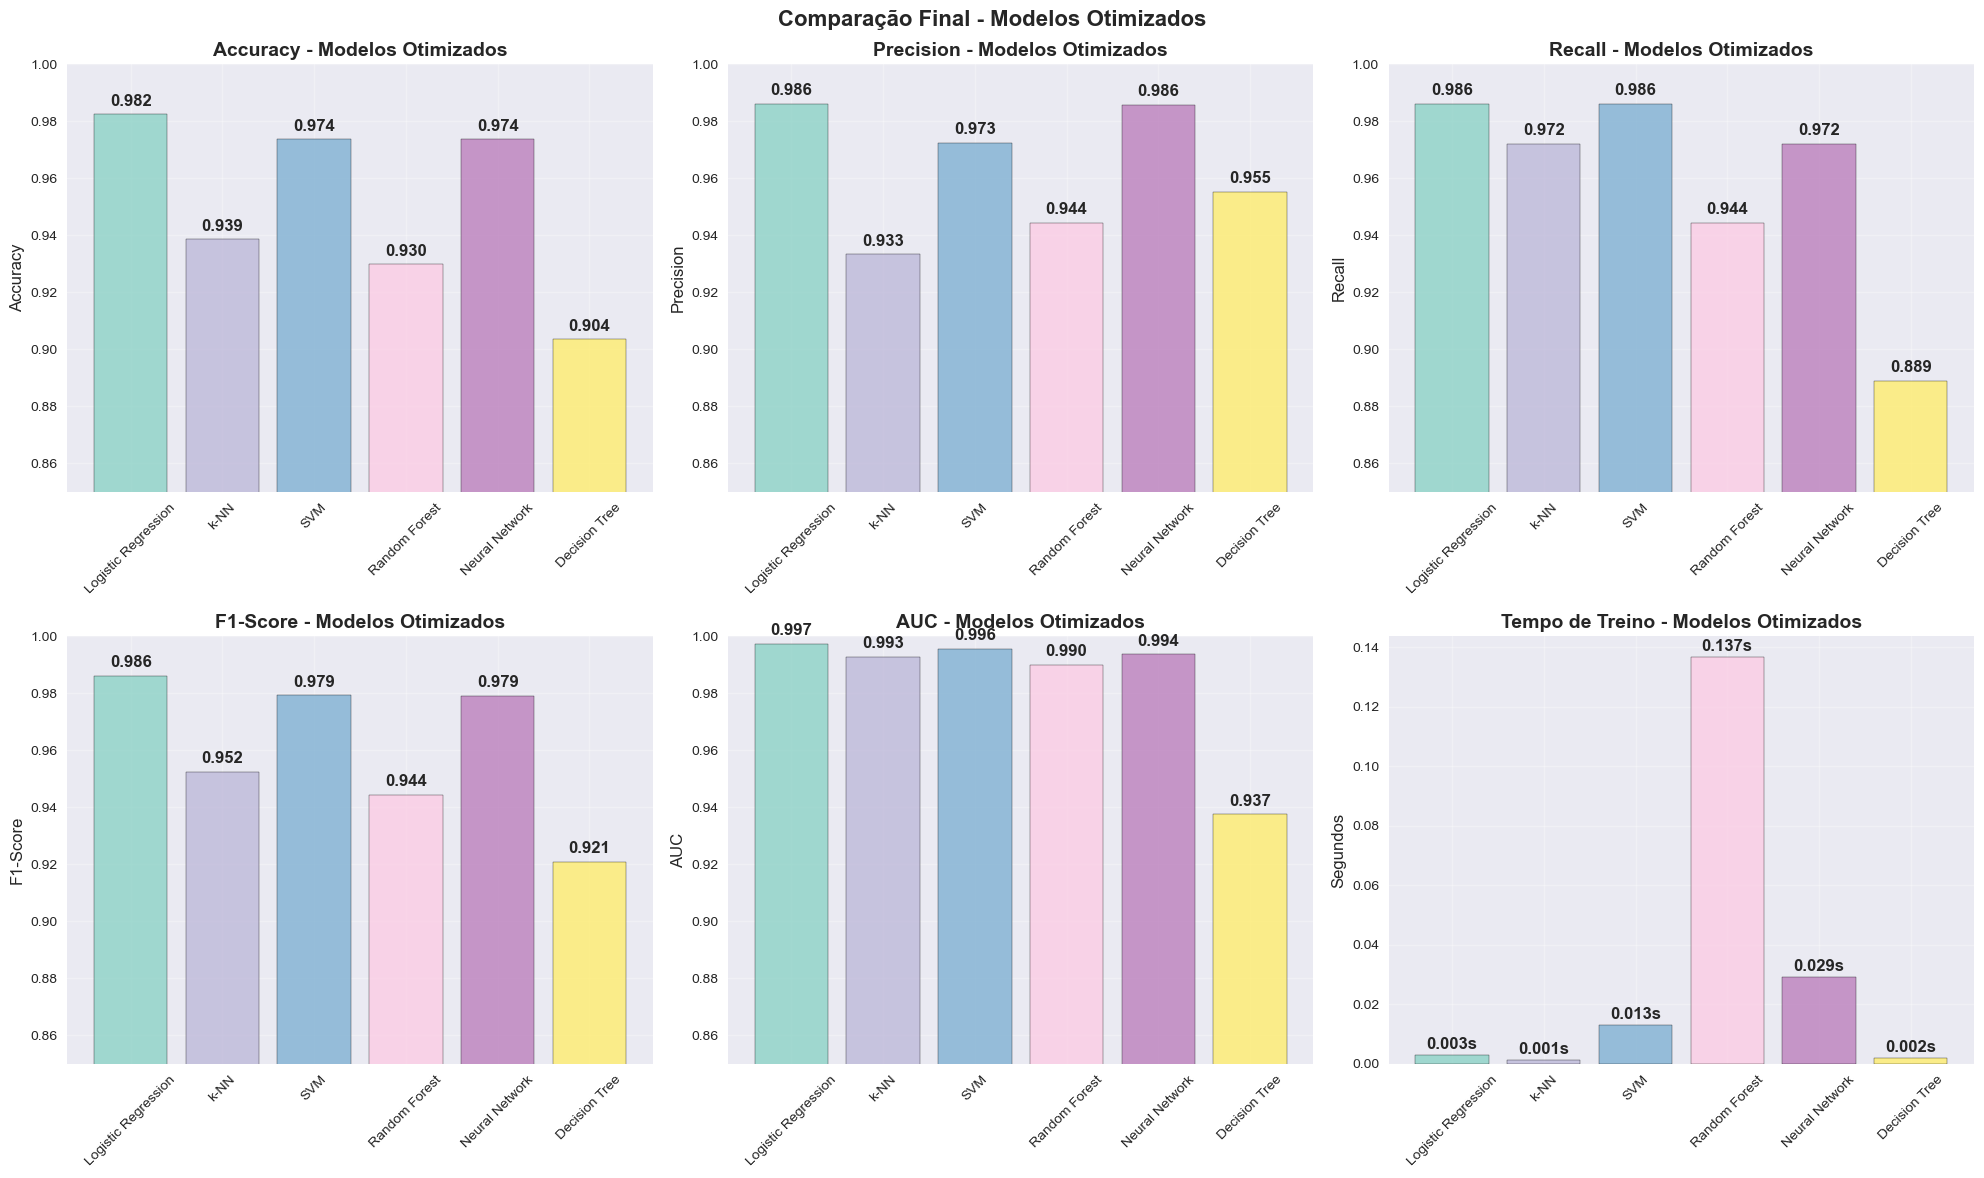

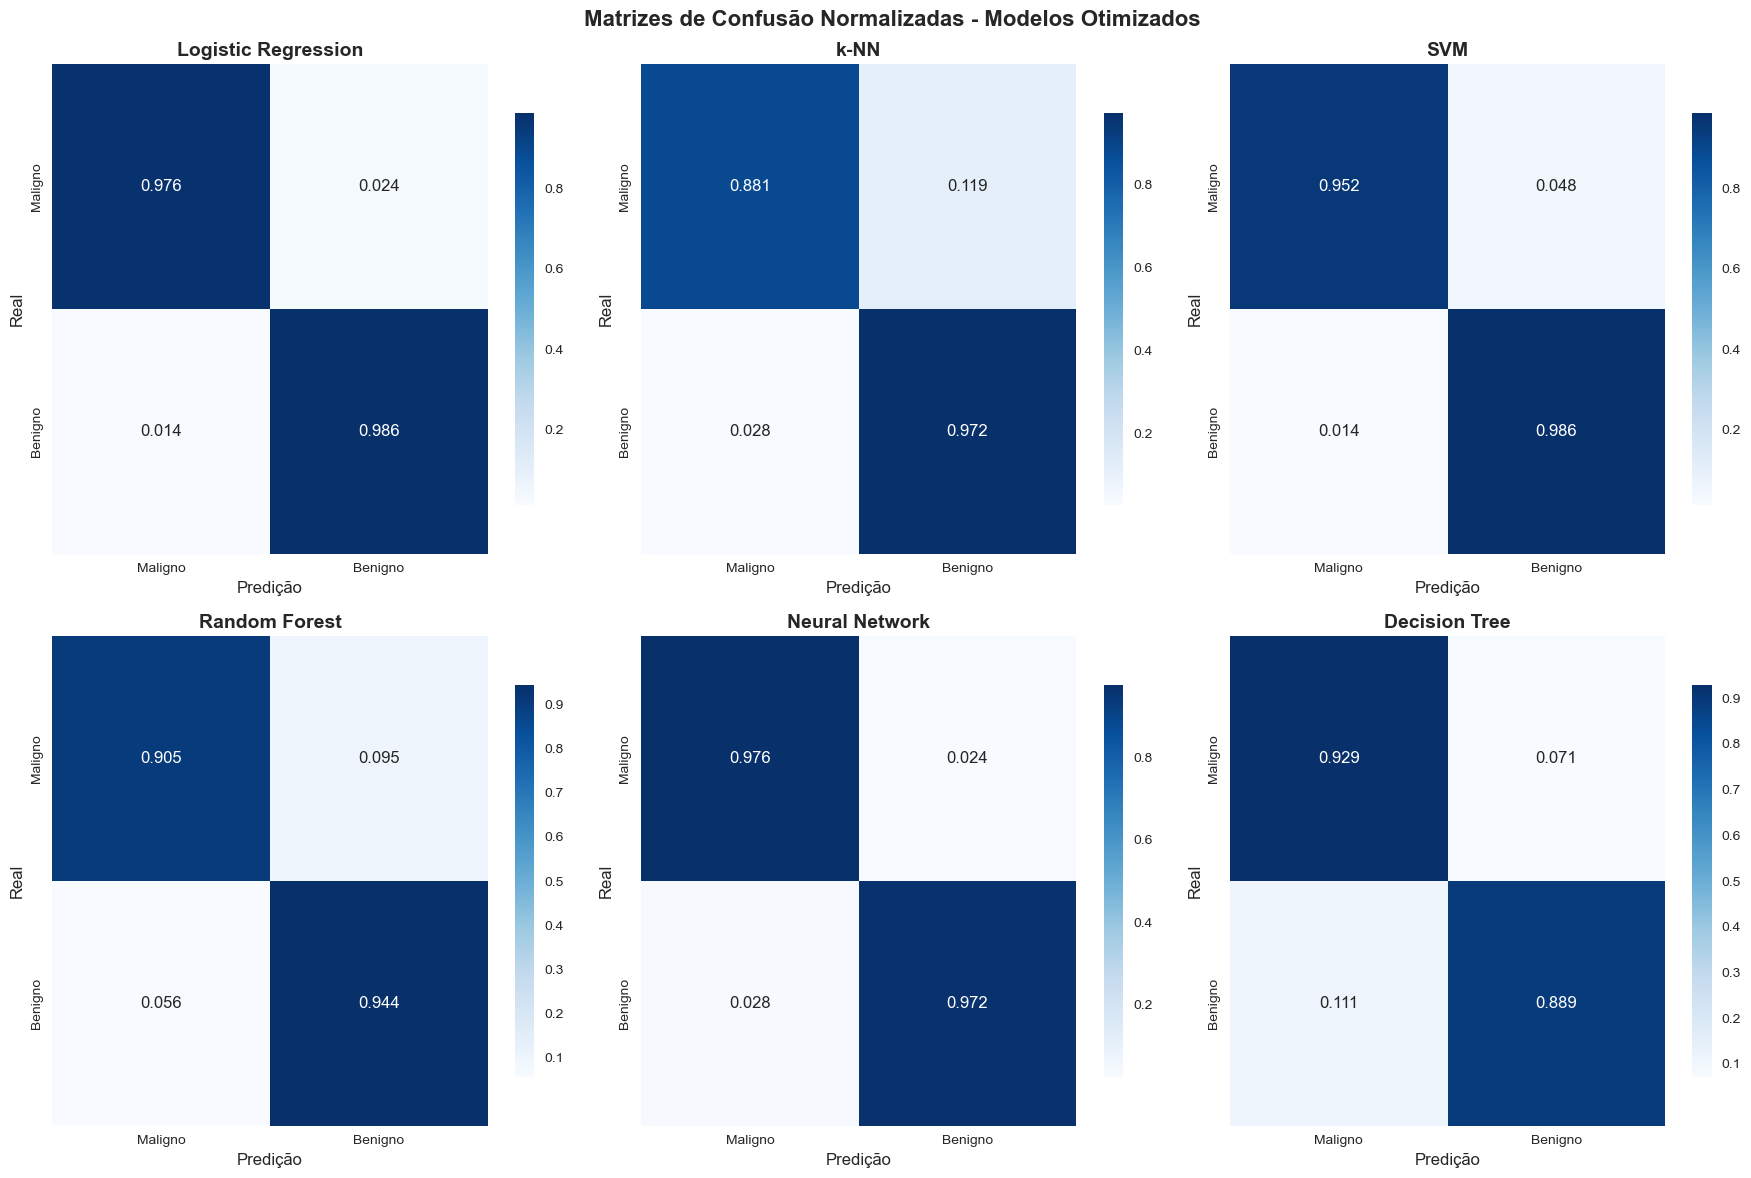

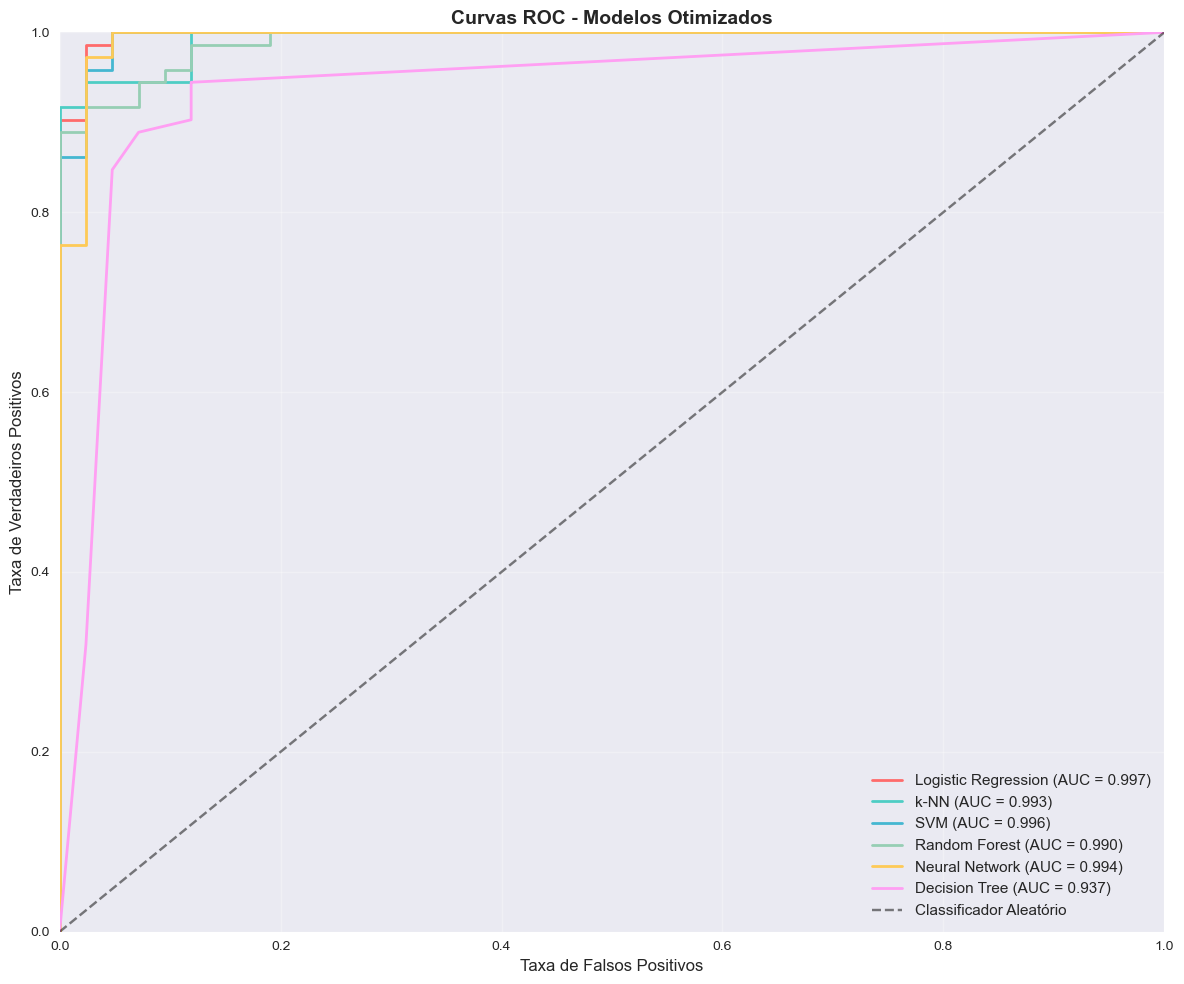

In [35]:
# 8.3 VISUALIZAÇÕES COMPARATIVAS
# ============================================================================

# 1. Gráfico de barras comparativo das métricas principais
metrics_for_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, metric in enumerate(metrics_for_plot):
    if idx < 5:
        values = [final_results[name][metric] for name in optimized_models.keys() 
                 if final_results[name][metric] is not None]
        names = [name for name in optimized_models.keys() 
                if final_results[name][metric] is not None]
        
        bars = axes[idx].bar(names, values, color=plt.cm.Set3(np.linspace(0, 1, len(names))), 
                           alpha=0.8, edgecolor='black')
        axes[idx].set_title(f'{metric} - Modelos Otimizados', fontweight='bold')
        axes[idx].set_ylabel(metric)
        axes[idx].set_ylim(0.85, 1.0)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, values):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de tempos
times = [final_results[name]['Training_Time'] for name in optimized_models.keys()]
bars = axes[5].bar(list(optimized_models.keys()), times, 
                  color=plt.cm.Set3(np.linspace(0, 1, len(optimized_models))), 
                  alpha=0.8, edgecolor='black')
axes[5].set_title('Tempo de Treino - Modelos Otimizados', fontweight='bold')
axes[5].set_ylabel('Segundos')
axes[5].tick_params(axis='x', rotation=45)
axes[5].grid(True, alpha=0.3)

for bar, value in zip(bars, times):
    axes[5].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação Final - Modelos Otimizados', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Matrizes de confusão
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    # Normalizar matriz de confusão
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Criar heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
               ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{name}', fontweight='bold')
    axes[idx].set_xlabel('Predição')
    axes[idx].set_ylabel('Real')
    axes[idx].set_xticklabels(['Maligno', 'Benigno'])
    axes[idx].set_yticklabels(['Maligno', 'Benigno'])

plt.suptitle('Matrizes de Confusão Normalizadas - Modelos Otimizados', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Curvas ROC sobrepostas
plt.figure(figsize=(12, 10))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
for i, (name, data) in enumerate(roc_data.items()):
    plt.plot(data['fpr'], data['tpr'], 
            label=f'{name} (AUC = {data["auc"]:.3f})',
            color=colors[i % len(colors)], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curvas ROC - Modelos Otimizados', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


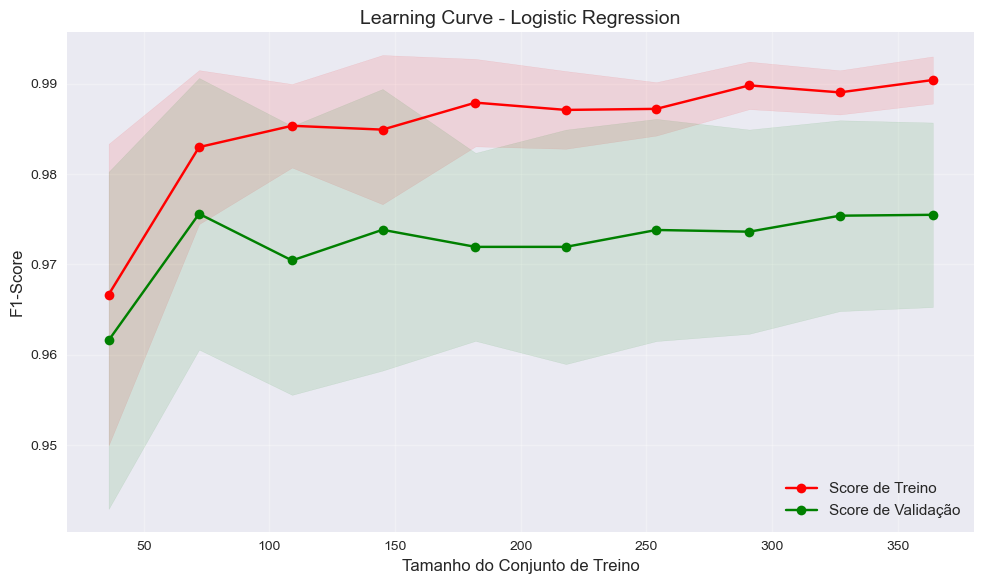

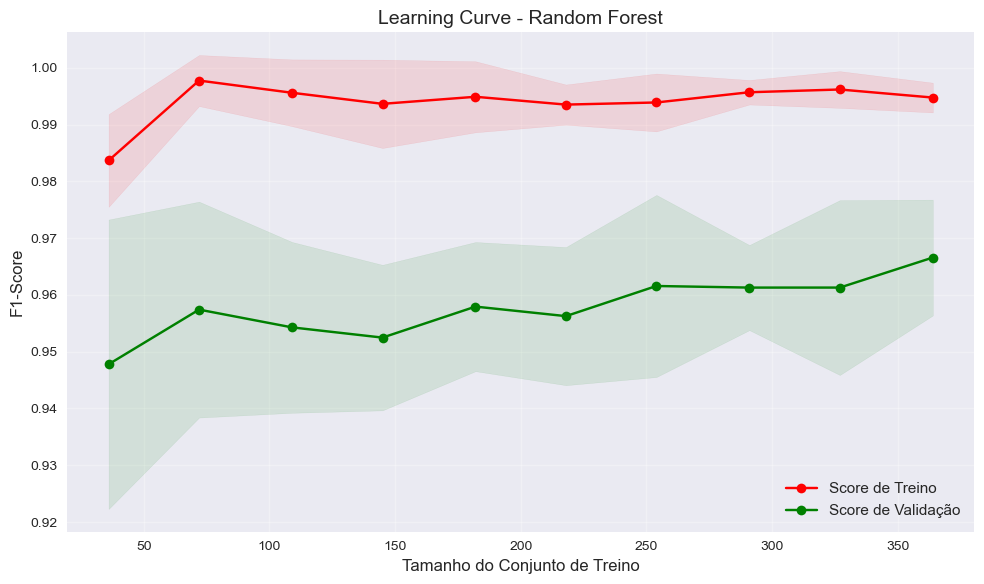

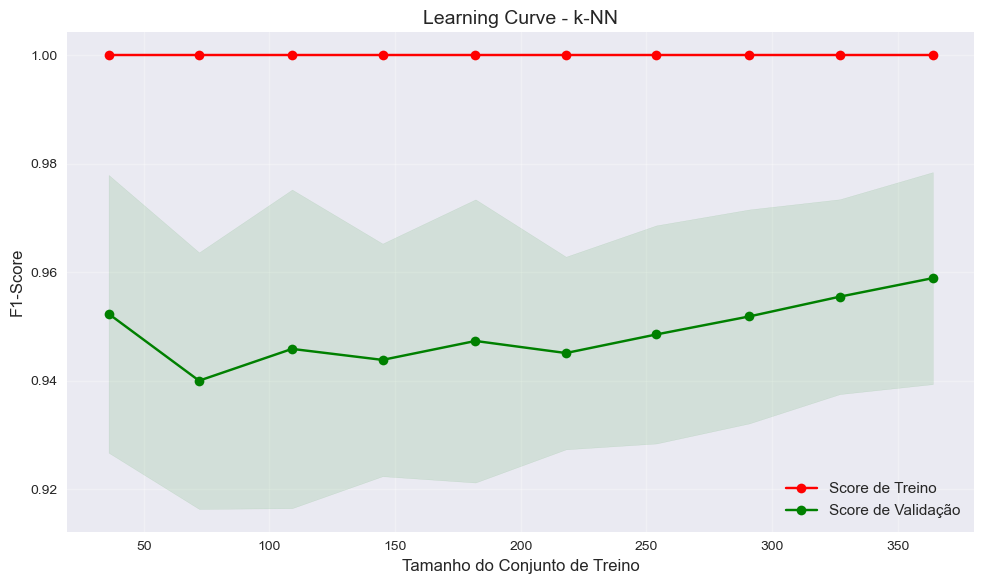

In [36]:
## 9. ANÁLISES AVANÇADAS
### 9.1 Learning Curves - Análise de Overfitting/Underfitting

# 9.1 LEARNING CURVES
# ============================================================================

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, 
                       train_sizes=np.linspace(.1, 1.0, 10)):
    """Plota learning curve para análise de overfitting"""
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring='f1', random_state=RANDOM_STATE)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de Validação")
    
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('F1-Score')
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return train_sizes, train_scores, test_scores

# Aplicar learning curves aos 3 melhores modelos
top_models = ['Logistic Regression', 'Random Forest', 'k-NN']

for model_name in top_models:
    plot_learning_curve(optimized_models[model_name], model_name, 
                       X_train_selected, y_train)

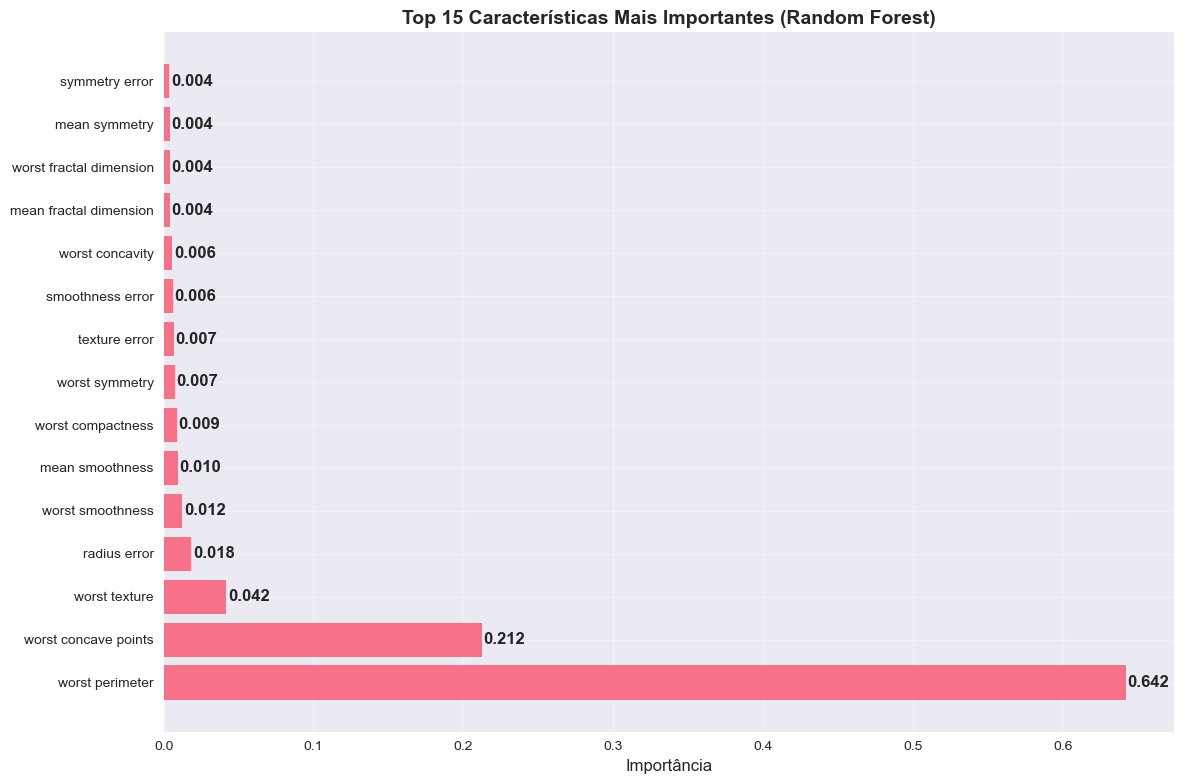

#### Top 10 Características Mais Importantes (Random Forest)

,Característica,Importância
13,worst perimeter,0.642089
17,worst concave points,0.212325
12,worst texture,0.041919
4,radius error,0.018485
14,worst smoothness,0.012475
0,mean smoothness,0.009728
15,worst compactness,0.008764
18,worst symmetry,0.007280
5,texture error,0.006861
6,smoothness error,0.006209


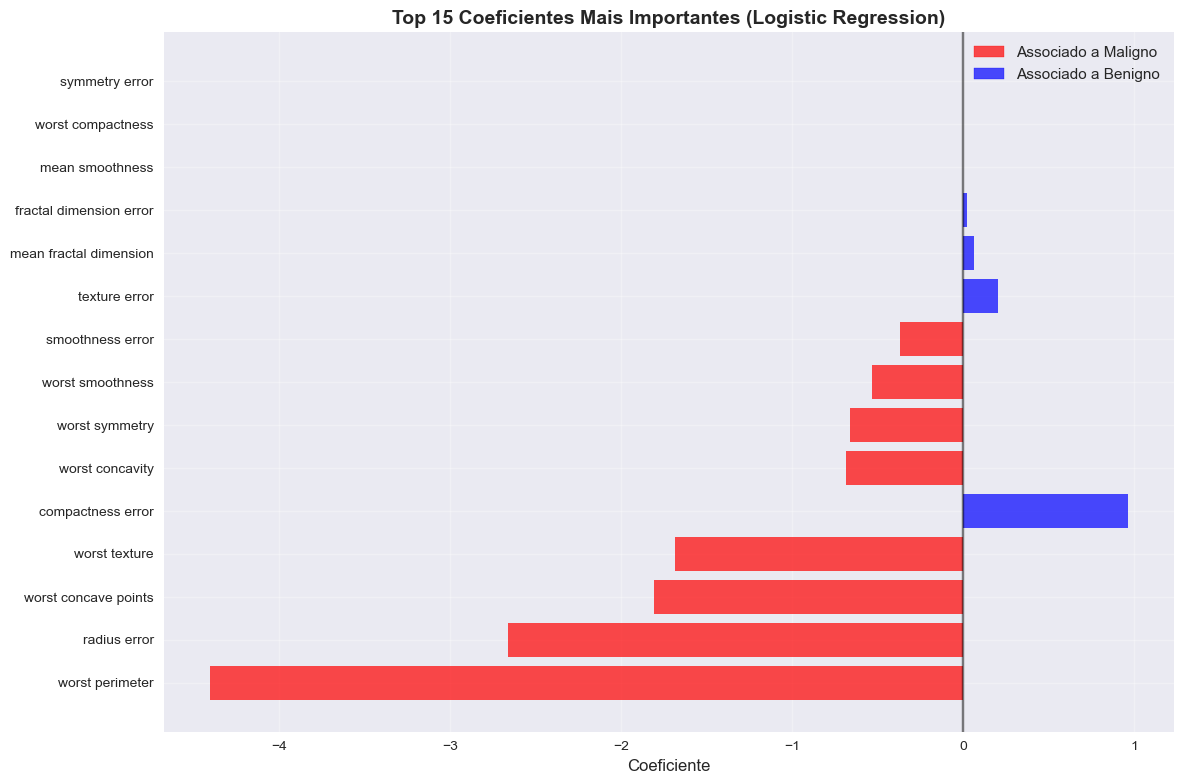

In [37]:
# 9.2 FEATURE IMPORTANCE
# ============================================================================

# Feature importance para Random Forest
if hasattr(best_rf, 'feature_importances_'):
    feature_importance_rf = pd.DataFrame({
        'Característica': X_train_selected.columns,
        'Importância': best_rf.feature_importances_
    }).sort_values('Importância', ascending=False)
    
    # Visualizar top 15 características mais importantes
    plt.figure(figsize=(12, 8))
    top_15_features = feature_importance_rf.head(15)
    bars = plt.barh(range(len(top_15_features)), top_15_features['Importância'].values)
    plt.yticks(range(len(top_15_features)), top_15_features['Característica'].values)
    plt.xlabel('Importância')
    plt.title('Top 15 Características Mais Importantes (Random Forest)', 
              fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, value) in enumerate(zip(bars, top_15_features['Importância'].values)):
        plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    display(Markdown("#### Top 10 Características Mais Importantes (Random Forest)"))
    display(feature_importance_rf.head(10))

# Coeficientes para Logistic Regression
if hasattr(best_lr, 'coef_'):
    coef_importance = pd.DataFrame({
        'Característica': X_train_selected.columns,
        'Coeficiente': best_lr.coef_[0],
        'Importância_Abs': np.abs(best_lr.coef_[0])
    }).sort_values('Importância_Abs', ascending=False)
    
    # Visualizar coeficientes
    plt.figure(figsize=(12, 8))
    top_15_coef = coef_importance.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_15_coef['Coeficiente']]
    bars = plt.barh(range(len(top_15_coef)), top_15_coef['Coeficiente'].values, 
                   color=colors, alpha=0.7)
    plt.yticks(range(len(top_15_coef)), top_15_coef['Característica'].values)
    plt.xlabel('Coeficiente')
    plt.title('Top 15 Coeficientes Mais Importantes (Logistic Regression)', 
              fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Legenda
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', alpha=0.7, label='Associado a Maligno')
    blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Associado a Benigno')
    plt.legend(handles=[red_patch, blue_patch])
    
    plt.tight_layout()
    plt.show()


#### Análise de Erros - Logistic Regression

,Tipo_Erro,Quantidade,Percentagem
0,Falsos Positivos,1,0.88
1,Falsos Negativos,1,0.88
2,Correctas,112,98.25


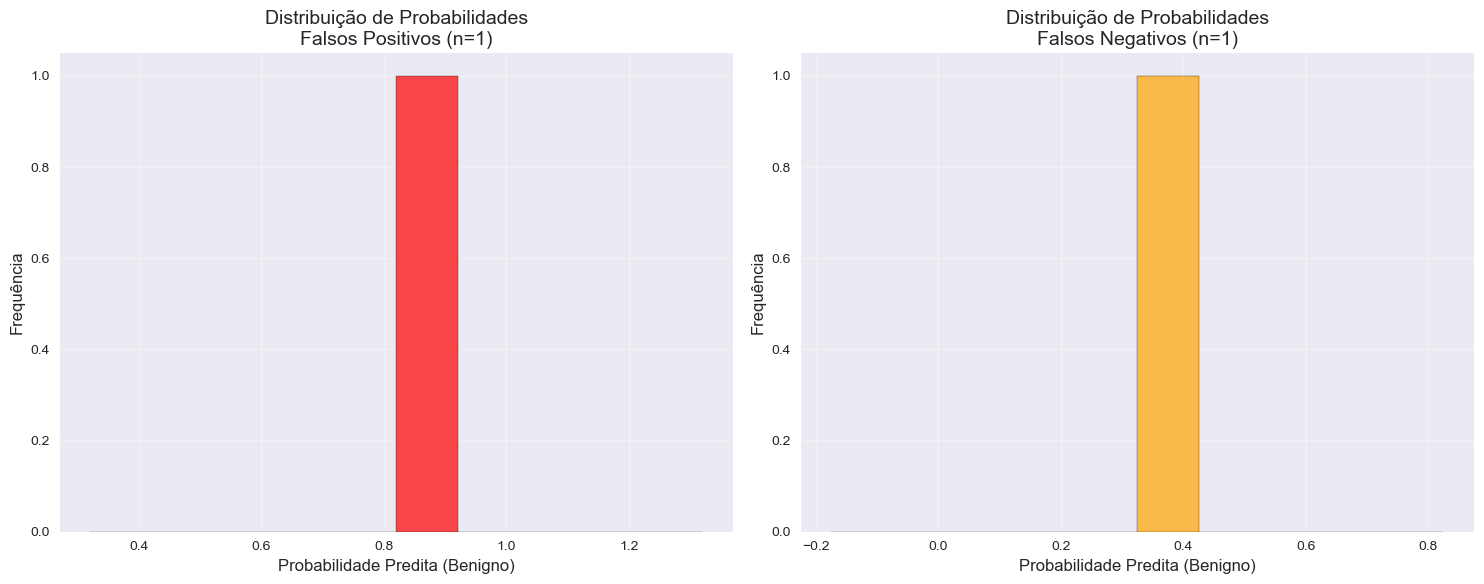

In [39]:
# 9.3 ANÁLISE DE ERROS
# ============================================================================

# Análise para o melhor modelo (assumindo Logistic Regression)
best_model = best_lr
y_pred_best = best_model.predict(X_test_selected)
y_pred_proba_best = best_model.predict_proba(X_test_selected)[:, 1]

# Identificar erros
false_positives = (y_test == 0) & (y_pred_best == 1)
false_negatives = (y_test == 1) & (y_pred_best == 0)

error_analysis = pd.DataFrame({
    'Tipo_Erro': ['Falsos Positivos', 'Falsos Negativos', 'Correctas'],
    'Quantidade': [false_positives.sum(), false_negatives.sum(), 
                  (y_test == y_pred_best).sum()],
    'Percentagem': [
        (false_positives.sum() / len(y_test)) * 100,
        (false_negatives.sum() / len(y_test)) * 100,
        ((y_test == y_pred_best).sum() / len(y_test)) * 100
    ]
}).round(2)

display(Markdown("#### Análise de Erros - Logistic Regression"))
display(error_analysis)

# Distribuição de probabilidades para casos mal classificados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

if false_positives.sum() > 0:
    fp_probs = y_pred_proba_best[false_positives]
    ax1.hist(fp_probs, bins=10, alpha=0.7, color='red', edgecolor='black')
    ax1.set_title(f'Distribuição de Probabilidades\nFalsos Positivos (n={false_positives.sum()})')
    ax1.set_xlabel('Probabilidade Predita (Benigno)')
    ax1.set_ylabel('Frequência')
    ax1.grid(True, alpha=0.3)

if false_negatives.sum() > 0:
    fn_probs = y_pred_proba_best[false_negatives]
    ax2.hist(fn_probs, bins=10, alpha=0.7, color='orange', edgecolor='black')
    ax2.set_title(f'Distribuição de Probabilidades\nFalsos Negativos (n={false_negatives.sum()})')
    ax2.set_xlabel('Probabilidade Predita (Benigno)')
    ax2.set_ylabel('Frequência')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()